# mean lfcc sweep

- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

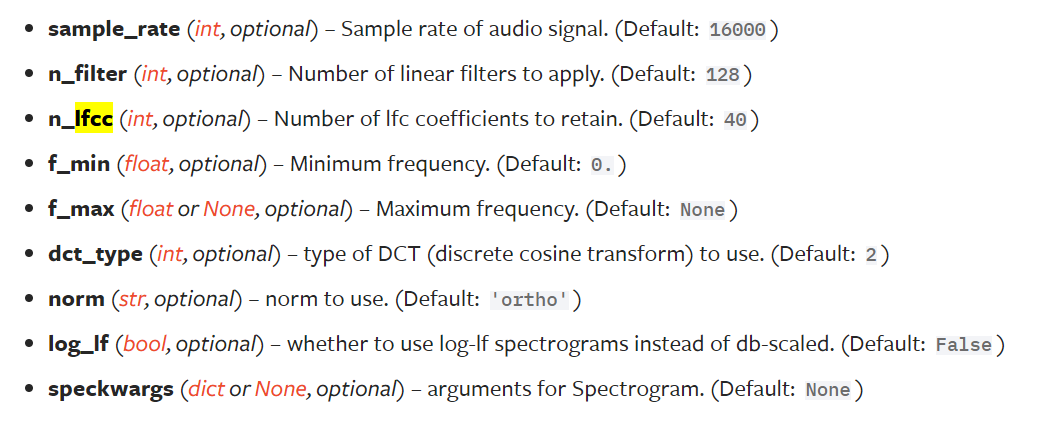

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
import wandb

#default param
run_config = dict(
    sr=16000,
    n_lfcc=40,
    n_filter=128,
    lifter =128,
    f_min = 0,
    f_max = 16000*2,
    
    
    # spectro kwargs
    hop_length=300,
    n_fft =1250,    
    win_length=1250,
    
    # training
    batch_size=16,
    
    # data
    fold=1,
)


In [4]:



sweep_config = {
    "project" : "SVD-lfcc-hyp",
    "name": "HyperParam for LFCC",
    "method": "random",
    "parameters": {
        "sr":{
            "values":[16000,]
        },
        "n_filter":{
          "values": np.arange(128,256,2).tolist()  
        },
        "n_lfcc":{
          "values":  np.arange(13,42,1).tolist()
        },
        "lifter":{
            "values":np.arange(0,42,1).tolist()
        },
       "n_fft": {
            "values": np.arange(256,20000,100).tolist() # 제일 중요한 파라미터
        },
       "win_length": {
            "values": np.arange(200,2051,50).tolist()
        },
       "hop_length": {
          "values": np.arange(50,850,50).tolist()
      },
       "f_max":{
          "values":np.arange(4000,25000,500).tolist()
      },
      "fold":{
          "values" : [1, ]
      }
    }
}

sweep_id = wandb.sweep(sweep_config,project="SVD-lfcc-hyp",entity="bub3690")



Create sweep with ID: 6j50g2sp
Sweep URL: https://wandb.ai/bub3690/SVD-lfcc-hyp/sweeps/6j50g2sp


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [5]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
#sr=16000
#win_length =  np.int64(sr/40) # 1250
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [6]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


## 2. stratified k-fold

In [7]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 95} 



## 3. random over sampling

In [8]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold3 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold4 
before dataset shape Counter({'healthy': 406, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})


In [9]:
import pickle

#16000 load
with open("D:/project/voice_pathology_ai/voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict_16000 = pickle.load(fr)

    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [10]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]
#sr=50000
#win_length =  np.int64(16000/40) # 400
#n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
#hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,lfcc_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes = classes
        self.transform = transform
        self.normalize = normalize
        
        # sweep params
        self.lfcc_params = lfcc_params
        
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig=None
        sample_f_max=None
        sample_win_length=None
        
        sig = phrase_dict_16000[self.path_list[idx]]  
            
        
        length = self.lfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        sig=torch.tensor(sig, dtype=torch.float32)
        
        #f-max 조절
        if self.lfcc_params["f_max"] >self.lfcc_params["sr"]/2:
            sample_f_max = self.lfcc_params["sr"]/2
            
        #win_size 조절
        if self.lfcc_params["win_length"] >self.lfcc_params["n_fft"]:
            sample_win_length=self.lfcc_params["n_fft"]
        

        
        LFCC = T.LFCC(
            sample_rate=self.lfcc_params["sr"],
            n_filter = self.lfcc_params["n_filter"],
            n_lfcc = self.lfcc_params["n_lfcc"],
            f_max = sample_f_max,
            log_lf =True,
            speckwargs={
                "hop_length" : self.lfcc_params["hop_length"],
                "n_fft" : self.lfcc_params["n_fft"],   
                "win_length" : sample_win_length,
            }
        )
        
        LFCCs=LFCC(sig)
        

        LFCCs = LFCCs[1:,]
        #MFCCs=(MFCCs-self.mfcc_normalize[0])/self.mfcc_normalize[1]
        (nframes, ncoeff) = LFCCs.shape
        cep_lifter = self.lfcc_params["lifter"]

        if cep_lifter > 0:
            n = np.arange(ncoeff)
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            LFCCs *= lift        
        
        if self.transform:
            LFCCs=LFCCs.type(torch.float32)# 타입 변화
            LFCCs=LFCCs.squeeze().mean(axis=1)
            
            # global normalize
            if self.normalize:
                LFCCs=self.normalize(LFCCs)            
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return LFCCs, self.classes.index(self.label[idx])
    
    

In [11]:

# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,lfcc_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        
        # sweep params
        self.lfcc_params = lfcc_params
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig=None
        sample_f_max=None
        sample_win_length=None
        
        sig = phrase_dict_16000[self.path_list[idx]]  
            
        
        length = self.lfcc_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        sig=torch.tensor(sig, dtype=torch.float32)
        
        #f-max 조절
        if self.lfcc_params["f_max"] >self.lfcc_params["sr"]/2:
            sample_f_max = self.lfcc_params["sr"]/2
            
        #win_size 조절
        if self.lfcc_params["win_length"] >self.lfcc_params["n_fft"]:
            sample_win_length=self.lfcc_params["n_fft"]
        

        
        LFCC = T.LFCC(
            sample_rate=self.lfcc_params["sr"],
            n_filter = self.lfcc_params["n_filter"],
            n_lfcc = self.lfcc_params["n_lfcc"],
            f_max = sample_f_max,
            log_lf =True,
            speckwargs={
                "hop_length" : self.lfcc_params["hop_length"],
                "n_fft" : self.lfcc_params["n_fft"],   
                "win_length" : sample_win_length,
            }
        )
        
        LFCCs=LFCC(sig)
        

        LFCCs = LFCCs[1:,]
        #MFCCs=(MFCCs-self.mfcc_normalize[0])/self.mfcc_normalize[1]
        (nframes, ncoeff) = LFCCs.shape
        cep_lifter = self.lfcc_params["lifter"]

        if cep_lifter > 0:
            n = np.arange(ncoeff)
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            LFCCs *= lift        
        
        if self.transform:
            LFCCs=LFCCs.type(torch.float32)# 타입 변화
            LFCCs=LFCCs.squeeze().mean(axis=1)
            
            # global normalize
            if self.normalize:
                LFCCs=self.normalize(LFCCs)            
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return LFCCs, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [12]:
#3. 하이퍼 파라미터
#BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복
lr=0.0001
augment_kind="no"


In [13]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),
                                               lfcc_params = dict(
                                                        sr = run_config["sr"],
                                                        n_lfcc=run_config["n_lfcc"],
                                                        n_filter=run_config["n_filter"],
                                                        lifter=run_config["lifter"],
                                                       
                                                        n_fft = run_config["n_fft"],
                                                        win_length = run_config["win_length"],
                                                        hop_length = run_config["hop_length"],
                                                        f_max = run_config["f_max"],
                                               ),
                                               data_num=run_config["fold"],
                                               training=True
                                           ),
                                           batch_size = run_config["batch_size"],
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               lfcc_params = dict(
                                                        sr = run_config["sr"],
                                                        n_lfcc=run_config["n_lfcc"],
                                                        n_filter=run_config["n_filter"],
                                                        lifter=run_config["lifter"],
                                                       
                                                        n_fft = run_config["n_fft"],
                                                        win_length = run_config["win_length"],
                                                        hop_length = run_config["hop_length"],
                                                        f_max = run_config["f_max"],
                                               ),                      
                                               #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                               
                                               data_num=run_config["fold"],
                                               training=False
                                           ),
                                           batch_size = run_config["batch_size"],
                                           shuffle = True,)



In [14]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   lfcc_params = dict(
                                                        sr = run_config["sr"],
                                                        n_lfcc=run_config["n_lfcc"],
                                                        n_filter=run_config["n_filter"],
                                                        lifter=run_config["lifter"],
                                                       
                                                        n_fft = run_config["n_fft"],
                                                        win_length = run_config["win_length"],
                                                        hop_length = run_config["hop_length"],
                                                        f_max = run_config["f_max"],
                                               ),                                            
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                                   
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = run_config["batch_size"],
                                               shuffle = True,) 

# 데이터 확인

In [15]:

sr=16000
win_length =  run_config["win_length"] # 400
n_fft= run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


In [16]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
print(X_train[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_train :  torch.Size([16, 39]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(1)
tensor([ 8.7448e+02,  2.3228e+02,  5.7679e+02, -3.0020e+01,  3.9332e+02,
        -4.7285e+01,  3.6300e+02, -6.6645e+01,  2.2649e+02, -1.9845e+02,
         6.7181e+01, -1.0783e+02,  2.2646e+02, -1.5790e+02,  3.1756e+01,
        -8.0855e+01,  5.8449e+01, -1.0138e+02,  4.4598e+01, -9.4402e+01,
         1.6089e+01, -6.7974e+01, -3.9721e+00, -6.2862e+01,  3.6750e+01,
        -6.4060e+01, -2.6632e+01, -6.5802e+01, -3.1802e-02, -7.4774e+01,
        -1.5338e+01, -3.1857e+01, -3.5389e+01, -5.6052e+01, -2.4414e+01,
        -3.5735e+01, -1.1716e+01, -3.9061e+01, -6.9328e+00])


In [17]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
print(X_valid[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 39]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(0)
tensor([ 952.5041,  232.3793,  337.9584,  -71.1564,  540.7261,  -57.6349,
         338.6505, -125.8788,  136.7286,  -96.3566,  222.4877, -147.1309,
         115.1229, -175.6609,   91.7052, -122.8099,   50.1645,  -69.5293,
          29.9601,  -66.6140,    7.5038, -117.0217,  -38.7287, -111.2467,
         -14.1404,  -55.4960,  -24.8744,  -61.7269,  -31.2658,  -50.9186,
           2.4097,  -33.3561,  -10.3096,  -60.9098,  -21.9706,  -29.8736,
           1.2320,   -1.0094,    8.4352])


In [18]:
#valiation set 확인
for (test_data,test_label) in validation_loader:
    print("X_test : ",test_data.size(),'type:',test_data.type())
    print("Y_test : ",test_label.size(),'type:',test_label.type())
    break

print(test_label[0])
print(test_data[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_test :  torch.Size([16, 39]) type: torch.FloatTensor
Y_test :  torch.Size([16]) type: torch.LongTensor
tensor(1)
tensor([1005.8447,  243.7096,  517.9951,   31.0613,  503.5712, -107.4354,
         253.2877, -121.2746,  259.9389, -198.2055,  108.9418, -102.3820,
         239.9184, -168.2403,   20.4720,  -55.9091,   32.2618,  -35.4387,
          90.9002, -106.5123,  -35.5769, -108.7959,    6.4565,  -81.6828,
         -40.1714, -116.7411,  -20.0155,  -54.7869,   30.8539,  -25.2257,
          -6.9193,  -35.0839,   30.3070,   -9.6004,   20.5345,  -40.9924,
          -1.2779,  -59.9195,   -7.8417])


# RESNET

In [19]:
# 모델 
# pretrained

class MfccDense(nn.Module):
    def __init__(self,in_dim):
        super(MfccDense, self).__init__()
        self.in_dim = in_dim
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        logits = self.fc(x)
        return logits    




def model_initialize(n_mfcc):
    model = MfccDense( in_dim=n_mfcc ).cuda()
    return model
model=model_initialize(run_config['n_lfcc']-1)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

MfccDense(
  (fc): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [21]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [22]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()    
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [23]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [24]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),
                                                   lfcc_params = dict(
                                                        sr = wandb.config.sr,
                                                        n_lfcc=wandb.config.n_lfcc,
                                                        n_filter=wandb.config.n_filter,
                                                        lifter=wandb.config.lifter,
                                                       
                                                        n_fft = wandb.config.n_fft,
                                                        win_length = wandb.config.win_length,
                                                        hop_length = wandb.config.hop_length,
                                                        f_max = wandb.config.f_max,                                                       
                                                   ),
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = wandb.config.batch_size,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   lfcc_params = dict(
                                                        sr = wandb.config.sr,
                                                        n_lfcc=wandb.config.n_lfcc,
                                                        n_filter=wandb.config.n_filter,
                                                        lifter=wandb.config.lifter,
                                                       
                                                        n_fft = wandb.config.n_fft,
                                                        win_length = wandb.config.win_length,
                                                        hop_length = wandb.config.hop_length,
                                                        f_max = wandb.config.f_max,         
                                                   ),                      
                                                   #normalize=transforms.Normalize((-56.4917, -56.4917,-56.4917), (17.9446,17.9446,17.9446)),                                               
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = wandb.config.batch_size,
                                               shuffle = True,) 

    return train_loader,validation_loader



In [25]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []



def all_train():
    wandb.init(project="SVD-lfcc-hyp", entity="bub3690",config=run_config)
    data_ind = wandb.config.fold
    check_path = '../../checkpoint/checkpoint_lfcc_ros_'+str(data_ind)+'_organics.pt'
    print(check_path)
    #wandb.run.name = 'n'### 여기 수정 ###
    print("config:", dict(wandb.config))    

    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)

    best_train_acc = 0 # accuracy 기록용
    best_valid_acc = 0
    
    best_train_loss = 0
    best_valid_loss = 0

    model=model_initialize(wandb.config.n_lfcc-1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        #wandb.log({"metric": run.config.param1, "epoch": epoch})
            
        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            best_train_loss, best_valid_loss = train_loss,valid_loss
            
            wandb.log({"Valid/Loss": best_valid_loss, 
                       "Valid/Accuracy": best_valid_acc,
                      }, step=Epoch)
            #wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        else:
            # 이전 최고 기록을 log
            wandb.log({"Valid/Loss": best_valid_loss, 
                       "Valid/Accuracy": best_valid_acc,
                      }, step=Epoch)

        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                #여기 최고기록만 갱신하면 5fold 가능.
                
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

In [ ]:
wandb.agent(sweep_id, function=all_train,count=300)

# 50번 돌리고 filter값을 정하자.

wandb: Agent Starting Run: ybwif4z1 with config:
wandb: 	f_max: 10500
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 15
wandb: 	n_fft: 4456
wandb: 	n_filter: 132
wandb: 	n_lfcc: 23
wandb: 	sr: 16000
wandb: 	win_length: 1300
wandb: Currently logged in as: bub3690. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 23, 'n_filter': 132, 'lifter': 15, 'f_min': 0, 'f_max': 10500, 'hop_length': 150, 'n_fft': 4456, 'win_length': 1300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0403	 Train Acc:62.81 %  | 	Valid Loss:0.0422 	Valid Acc: 64.97 %

Validation loss decreased (inf --> 0.042195).  Saving model ...

[EPOCH:2]	 Train Loss:0.0385	 Train Acc:66.38 %  | 	Valid Loss:0.0422 	Valid Acc: 65.99 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0380	 Train Acc:68.35 %  | 	Valid Loss:0.0413 	Valid Acc: 66.50 %

Validation loss decreased (0.042195 --> 0.041265).  Saving model ...

[EPOCH:4]	 Train Loss:0.0372	 Train Acc:67.24 %  | 	Valid Loss:0.0413 	Valid Acc: 67.51 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0368	 Train Acc:67.98 %  | 	Valid Loss:0.0419 	Valid Acc: 67.51 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0353	 Train Acc:70.81 %  | 	

Valid/Accuracy,▁▁███▆▆▆▆▆▆▆
Valid/Loss,██▆▆▆▂▁▁▁▁▁▁
Valid/Accuracy,65.98985
Valid/Loss,0.03911


wandb: Agent Starting Run: 2k63kkf4 with config:
wandb: 	f_max: 9500
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 16
wandb: 	n_fft: 17156
wandb: 	n_filter: 166
wandb: 	n_lfcc: 40
wandb: 	sr: 16000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 40, 'n_filter': 166, 'lifter': 16, 'f_min': 0, 'f_max': 9500, 'hop_length': 350, 'n_fft': 17156, 'win_length': 950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0412	 Train Acc:60.84 %  | 	Valid Loss:0.0433 	Valid Acc: 58.38 %

Validation loss decreased (inf --> 0.043310).  Saving model ...

[EPOCH:2]	 Train Loss:0.0393	 Train Acc:64.04 %  | 	Valid Loss:0.0436 	Valid Acc: 56.85 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0379	 Train Acc:66.87 %  | 	Valid Loss:0.0439 	Valid Acc: 55.84 %

EarlyStopping counter: 2 out of 5

[EPOCH:4]	 Train Loss:0.0371	 Train Acc:69.21 %  | 	Valid Loss:0.0429 	Valid Acc: 57.36 %

Validation loss decreased (0.043310 --> 0.042947).  Saving model ...

[EPOCH:5]	 Train Loss:0.0364	 Train Acc:69.33 %  | 	Valid Loss:0.0429 	Valid Acc: 57.87 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0359	 Train Acc:70.32 %  | 	V

Valid/Accuracy,███▁▁▁▁▁▁
Valid/Loss,███▁▁▁▁▁▁
Valid/Accuracy,57.36041
Valid/Loss,0.04295


wandb: Agent Starting Run: kvgibb3q with config:
wandb: 	f_max: 19500
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 24
wandb: 	n_fft: 9956
wandb: 	n_filter: 208
wandb: 	n_lfcc: 19
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 19, 'n_filter': 208, 'lifter': 24, 'f_min': 0, 'f_max': 19500, 'hop_length': 800, 'n_fft': 9956, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0400	 Train Acc:63.55 %  | 	Valid Loss:0.0413 	Valid Acc: 65.99 %

Validation loss decreased (inf --> 0.041309).  Saving model ...

[EPOCH:2]	 Train Loss:0.0352	 Train Acc:72.54 %  | 	Valid Loss:0.0386 	Valid Acc: 67.01 %

Validation loss decreased (0.041309 --> 0.038602).  Saving model ...

[EPOCH:3]	 Train Loss:0.0333	 Train Acc:75.99 %  | 	Valid Loss:0.0385 	Valid Acc: 69.54 %

Validation loss decreased (0.038602 --> 0.038498).  Saving model ...

[EPOCH:4]	 Train Loss:0.0318	 Train Acc:76.72 %  | 	Valid Loss:0.0380 	Valid Acc: 67.51 %

Validation loss decreased (0.038498 --> 0.038038).  Saving model ...

[EPOCH:5]	 Train Loss:0.0318	 Train Acc:74.63 %  | 	Valid Loss:0.0377 	Valid Acc: 69.54 %

Validation loss d

Valid/Accuracy,▁▃█▄██████
Valid/Loss,█▃▃▂▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03767


wandb: Agent Starting Run: 57mbsum0 with config:
wandb: 	f_max: 5000
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	lifter: 5
wandb: 	n_fft: 2756
wandb: 	n_filter: 118
wandb: 	n_lfcc: 19
wandb: 	sr: 16000
wandb: 	win_length: 1300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 19, 'n_filter': 118, 'lifter': 5, 'f_min': 0, 'f_max': 5000, 'hop_length': 50, 'n_fft': 2756, 'win_length': 1300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0422	 Train Acc:59.11 %  | 	Valid Loss:0.0442 	Valid Acc: 58.38 %

Validation loss decreased (inf --> 0.044168).  Saving model ...

[EPOCH:2]	 Train Loss:0.0385	 Train Acc:66.63 %  | 	Valid Loss:0.0422 	Valid Acc: 65.48 %

Validation loss decreased (0.044168 --> 0.042243).  Saving model ...

[EPOCH:3]	 Train Loss:0.0364	 Train Acc:70.44 %  | 	Valid Loss:0.0421 	Valid Acc: 67.01 %

Validation loss decreased (0.042243 --> 0.042075).  Saving model ...

[EPOCH:4]	 Train Loss:0.0351	 Train Acc:73.03 %  | 	Valid Loss:0.0417 	Valid Acc: 67.01 %

Validation loss decreased (0.042075 --> 0.041724).  Saving model ...

[EPOCH:5]	 Train Loss:0.0340	 Train Acc:74.51 %  | 	Valid Loss:0.0412 	Valid Acc: 68.02 %

Validation loss decr

Valid/Accuracy,▁▅▅▅▆▆▆▆▇▇▇▇▇▇██████
Valid/Loss,█▆▆▆▅▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,72.58883
Valid/Loss,0.03636


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m5t2yyxm with config:
wandb: 	f_max: 13000
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 12
wandb: 	n_fft: 19856
wandb: 	n_filter: 84
wandb: 	n_lfcc: 40
wandb: 	sr: 16000
wandb: 	win_length: 1050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 40, 'n_filter': 84, 'lifter': 12, 'f_min': 0, 'f_max': 13000, 'hop_length': 250, 'n_fft': 19856, 'win_length': 1050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0408	 Train Acc:60.34 %  | 	Valid Loss:0.0411 	Valid Acc: 62.44 %

Validation loss decreased (inf --> 0.041139).  Saving model ...

[EPOCH:2]	 Train Loss:0.0365	 Train Acc:71.92 %  | 	Valid Loss:0.0400 	Valid Acc: 66.50 %

Validation loss decreased (0.041139 --> 0.039995).  Saving model ...

[EPOCH:3]	 Train Loss:0.0346	 Train Acc:73.89 %  | 	Valid Loss:0.0409 	Valid Acc: 64.47 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0335	 Train Acc:72.54 %  | 	Valid Loss:0.0396 	Valid Acc: 65.48 %

Validation loss decreased (0.039995 --> 0.039573).  Saving model ...

[EPOCH:5]	 Train Loss:0.0327	 Train Acc:75.49 %  | 	Valid Loss:0.0411 	Valid Acc: 67.51 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁██▆▆▆▆▆▆
Valid/Loss,█▃▃▁▁▁▁▁▁
Valid/Accuracy,65.48223
Valid/Loss,0.03957


wandb: Agent Starting Run: ck6n5pge with config:
wandb: 	f_max: 11000
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 14
wandb: 	n_fft: 7456
wandb: 	n_filter: 218
wandb: 	n_lfcc: 18
wandb: 	sr: 16000
wandb: 	win_length: 1050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 18, 'n_filter': 218, 'lifter': 14, 'f_min': 0, 'f_max': 11000, 'hop_length': 800, 'n_fft': 7456, 'win_length': 1050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0402	 Train Acc:62.93 %  | 	Valid Loss:0.0383 	Valid Acc: 73.10 %

Validation loss decreased (inf --> 0.038300).  Saving model ...

[EPOCH:2]	 Train Loss:0.0333	 Train Acc:75.62 %  | 	Valid Loss:0.0355 	Valid Acc: 72.08 %

Validation loss decreased (0.038300 --> 0.035528).  Saving model ...

[EPOCH:3]	 Train Loss:0.0311	 Train Acc:78.33 %  | 	Valid Loss:0.0348 	Valid Acc: 73.60 %

Validation loss decreased (0.035528 --> 0.034765).  Saving model ...

[EPOCH:4]	 Train Loss:0.0299	 Train Acc:79.31 %  | 	Valid Loss:0.0359 	Valid Acc: 70.56 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0293	 Train Acc:78.94 %  | 	Valid Loss:0.0366 	Valid Acc: 71.07 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▆▁███▆▆▆▆▆▆
Valid/Loss,█▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,73.09645
Valid/Loss,0.03442


wandb: Agent Starting Run: llvrroy2 with config:
wandb: 	f_max: 15500
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	lifter: 12
wandb: 	n_fft: 10756
wandb: 	n_filter: 110
wandb: 	n_lfcc: 36
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 36, 'n_filter': 110, 'lifter': 12, 'f_min': 0, 'f_max': 15500, 'hop_length': 50, 'n_fft': 10756, 'win_length': 700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0433	 Train Acc:57.64 %  | 	Valid Loss:0.0423 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.042266).  Saving model ...

[EPOCH:2]	 Train Loss:0.0376	 Train Acc:70.44 %  | 	Valid Loss:0.0403 	Valid Acc: 68.53 %

Validation loss decreased (0.042266 --> 0.040250).  Saving model ...

[EPOCH:3]	 Train Loss:0.0350	 Train Acc:72.78 %  | 	Valid Loss:0.0409 	Valid Acc: 68.02 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0336	 Train Acc:74.88 %  | 	Valid Loss:0.0403 	Valid Acc: 70.56 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0328	 Train Acc:74.75 %  | 	Valid Loss:0.0394 	Valid Acc: 70.56 %

Validation loss decreased (0.040250 --> 0.039411).  Saving model ...

[EPOCH:6]	 Train L

Valid/Accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇███████████
Valid/Loss,█▆▆▆▅▄▄▄▄▄▄▄▄▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03551


wandb: Agent Starting Run: 04rpbyd2 with config:
wandb: 	f_max: 18500
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 37
wandb: 	n_fft: 7556
wandb: 	n_filter: 218
wandb: 	n_lfcc: 31
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 31, 'n_filter': 218, 'lifter': 37, 'f_min': 0, 'f_max': 18500, 'hop_length': 650, 'n_fft': 7556, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0407	 Train Acc:61.82 %  | 	Valid Loss:0.0419 	Valid Acc: 67.01 %

Validation loss decreased (inf --> 0.041885).  Saving model ...

[EPOCH:2]	 Train Loss:0.0369	 Train Acc:70.44 %  | 	Valid Loss:0.0396 	Valid Acc: 69.54 %

Validation loss decreased (0.041885 --> 0.039586).  Saving model ...

[EPOCH:3]	 Train Loss:0.0349	 Train Acc:73.89 %  | 	Valid Loss:0.0407 	Valid Acc: 69.04 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0335	 Train Acc:73.65 %  | 	Valid Loss:0.0395 	Valid Acc: 69.54 %

Validation loss decreased (0.039586 --> 0.039512).  Saving model ...

[EPOCH:5]	 Train Loss:0.0328	 Train Acc:75.37 %  | 	Valid Loss:0.0395 	Valid Acc: 68.53 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁▃▃▃▃▁▂▂▅▅▅▆▆▆▆██████
Valid/Loss,█▅▅▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,74.61929
Valid/Loss,0.0364


wandb: Agent Starting Run: mey8ws4b with config:
wandb: 	f_max: 5000
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 37
wandb: 	n_fft: 1556
wandb: 	n_filter: 180
wandb: 	n_lfcc: 30
wandb: 	sr: 16000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 30, 'n_filter': 180, 'lifter': 37, 'f_min': 0, 'f_max': 5000, 'hop_length': 650, 'n_fft': 1556, 'win_length': 600, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0464	 Train Acc:50.25 %  | 	Valid Loss:0.0448 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.044801).  Saving model ...

[EPOCH:2]	 Train Loss:0.0401	 Train Acc:65.52 %  | 	Valid Loss:0.0416 	Valid Acc: 64.97 %

Validation loss decreased (0.044801 --> 0.041604).  Saving model ...

[EPOCH:3]	 Train Loss:0.0373	 Train Acc:69.09 %  | 	Valid Loss:0.0422 	Valid Acc: 65.48 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0364	 Train Acc:70.20 %  | 	Valid Loss:0.0397 	Valid Acc: 68.02 %

Validation loss decreased (0.041604 --> 0.039737).  Saving model ...

[EPOCH:5]	 Train Loss:0.0350	 Train Acc:71.55 %  | 	Valid Loss:0.0387 	Valid Acc: 65.48 %

Validation loss decreased (0.039737 --> 0.038745).  Sa

Valid/Accuracy,▁▄▄▆▅▅▅▆▆██████
Valid/Loss,█▅▅▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,70.55838
Valid/Loss,0.03784


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yk7etdy7 with config:
wandb: 	f_max: 21500
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 24
wandb: 	n_fft: 9556
wandb: 	n_filter: 226
wandb: 	n_lfcc: 24
wandb: 	sr: 16000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 24, 'n_filter': 226, 'lifter': 24, 'f_min': 0, 'f_max': 21500, 'hop_length': 800, 'n_fft': 9556, 'win_length': 400, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0377	 Train Acc:67.73 %  | 	Valid Loss:0.0423 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.042333).  Saving model ...

[EPOCH:2]	 Train Loss:0.0344	 Train Acc:74.14 %  | 	Valid Loss:0.0430 	Valid Acc: 65.48 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0326	 Train Acc:75.37 %  | 	Valid Loss:0.0407 	Valid Acc: 66.50 %

Validation loss decreased (0.042333 --> 0.040652).  Saving model ...

[EPOCH:4]	 Train Loss:0.0322	 Train Acc:76.11 %  | 	Valid Loss:0.0403 	Valid Acc: 66.50 %

Validation loss decreased (0.040652 --> 0.040328).  Saving model ...

[EPOCH:5]	 Train Loss:0.0316	 Train Acc:76.48 %  | 	Valid Loss:0.0392 	Valid Acc: 67.01 %

Validation loss decreased (0.040328 --> 0.039160).  S

Valid/Accuracy,▁▁▇▇██████
Valid/Loss,██▄▄▁▁▁▁▁▁
Valid/Accuracy,67.00508
Valid/Loss,0.03916


wandb: Agent Starting Run: k9rhl44j with config:
wandb: 	f_max: 11500
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 27
wandb: 	n_fft: 456
wandb: 	n_filter: 218
wandb: 	n_lfcc: 39
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 39, 'n_filter': 218, 'lifter': 27, 'f_min': 0, 'f_max': 11500, 'hop_length': 700, 'n_fft': 456, 'win_length': 450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0437	 Train Acc:57.76 %  | 	Valid Loss:0.0441 	Valid Acc: 63.45 %

Validation loss decreased (inf --> 0.044064).  Saving model ...

[EPOCH:2]	 Train Loss:0.0376	 Train Acc:68.84 %  | 	Valid Loss:0.0403 	Valid Acc: 67.01 %

Validation loss decreased (0.044064 --> 0.040317).  Saving model ...

[EPOCH:3]	 Train Loss:0.0353	 Train Acc:71.80 %  | 	Valid Loss:0.0399 	Valid Acc: 67.51 %

Validation loss decreased (0.040317 --> 0.039868).  Saving model ...

[EPOCH:4]	 Train Loss:0.0342	 Train Acc:73.03 %  | 	Valid Loss:0.0397 	Valid Acc: 69.04 %

Validation loss decreased (0.039868 --> 0.039679).  Saving model ...

[EPOCH:5]	 Train Loss:0.0333	 Train Acc:73.65 %  | 	Valid Loss:0.0401 	Valid Acc: 70.05 %

EarlyStopping count

Valid/Accuracy,▁▅▅▇▇█▅▅▅▅▄▄▄▄▅▅▅▅▅▅
Valid/Loss,█▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,67.00508
Valid/Loss,0.0377


wandb: Agent Starting Run: ftpoha81 with config:
wandb: 	f_max: 22500
wandb: 	fold: 1
wandb: 	hop_length: 550
wandb: 	lifter: 15
wandb: 	n_fft: 17456
wandb: 	n_filter: 216
wandb: 	n_lfcc: 37
wandb: 	sr: 16000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 37, 'n_filter': 216, 'lifter': 15, 'f_min': 0, 'f_max': 22500, 'hop_length': 550, 'n_fft': 17456, 'win_length': 850, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0462	 Train Acc:47.54 %  | 	Valid Loss:0.0442 	Valid Acc: 58.38 %

Validation loss decreased (inf --> 0.044202).  Saving model ...

[EPOCH:2]	 Train Loss:0.0416	 Train Acc:61.08 %  | 	Valid Loss:0.0428 	Valid Acc: 62.94 %

Validation loss decreased (0.044202 --> 0.042813).  Saving model ...

[EPOCH:3]	 Train Loss:0.0393	 Train Acc:67.24 %  | 	Valid Loss:0.0417 	Valid Acc: 63.45 %

Validation loss decreased (0.042813 --> 0.041672).  Saving model ...

[EPOCH:4]	 Train Loss:0.0380	 Train Acc:68.97 %  | 	Valid Loss:0.0413 	Valid Acc: 64.97 %

Validation loss decreased (0.041672 --> 0.041284).  Saving model ...

[EPOCH:5]	 Train Loss:0.0374	 Train Acc:69.33 %  | 	Valid Loss:0.0411 	Valid Acc: 65.48 %

Validation loss d

Valid/Accuracy,▁▆▆▇█▆▆▆▆▆▆
Valid/Loss,█▆▄▃▃▁▁▁▁▁▁
Valid/Accuracy,62.94416
Valid/Loss,0.0401


wandb: Agent Starting Run: nfz7gzn2 with config:
wandb: 	f_max: 14000
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 3
wandb: 	n_fft: 3956
wandb: 	n_filter: 190
wandb: 	n_lfcc: 31
wandb: 	sr: 16000
wandb: 	win_length: 1550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 31, 'n_filter': 190, 'lifter': 3, 'f_min': 0, 'f_max': 14000, 'hop_length': 450, 'n_fft': 3956, 'win_length': 1550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0447	 Train Acc:52.22 %  | 	Valid Loss:0.0464 	Valid Acc: 56.35 %

Validation loss decreased (inf --> 0.046389).  Saving model ...

[EPOCH:2]	 Train Loss:0.0388	 Train Acc:68.84 %  | 	Valid Loss:0.0479 	Valid Acc: 60.91 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0361	 Train Acc:71.80 %  | 	Valid Loss:0.0437 	Valid Acc: 65.48 %

Validation loss decreased (0.046389 --> 0.043690).  Saving model ...

[EPOCH:4]	 Train Loss:0.0344	 Train Acc:74.51 %  | 	Valid Loss:0.0408 	Valid Acc: 64.97 %

Validation loss decreased (0.043690 --> 0.040802).  Saving model ...

[EPOCH:5]	 Train Loss:0.0337	 Train Acc:74.26 %  | 	Valid Loss:0.0400 	Valid Acc: 68.02 %

Validation loss decreased (0.040802 --> 0.039972).  S

Valid/Accuracy,▁▁▅▅▆▆▇▇████████▇▇▇▇▇▇
Valid/Loss,██▆▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,70.05076
Valid/Loss,0.03656


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hdsihtd5 with config:
wandb: 	f_max: 6500
wandb: 	fold: 1
wandb: 	hop_length: 200
wandb: 	lifter: 31
wandb: 	n_fft: 19656
wandb: 	n_filter: 248
wandb: 	n_lfcc: 31
wandb: 	sr: 16000
wandb: 	win_length: 1300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 31, 'n_filter': 248, 'lifter': 31, 'f_min': 0, 'f_max': 6500, 'hop_length': 200, 'n_fft': 19656, 'win_length': 1300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0476	 Train Acc:47.41 %  | 	Valid Loss:0.0439 	Valid Acc: 62.44 %

Validation loss decreased (inf --> 0.043865).  Saving model ...

[EPOCH:2]	 Train Loss:0.0403	 Train Acc:64.04 %  | 	Valid Loss:0.0424 	Valid Acc: 64.47 %

Validation loss decreased (0.043865 --> 0.042406).  Saving model ...

[EPOCH:3]	 Train Loss:0.0379	 Train Acc:67.36 %  | 	Valid Loss:0.0411 	Valid Acc: 63.96 %

Validation loss decreased (0.042406 --> 0.041052).  Saving model ...

[EPOCH:4]	 Train Loss:0.0370	 Train Acc:71.06 %  | 	Valid Loss:0.0407 	Valid Acc: 65.48 %

Validation loss decreased (0.041052 --> 0.040681).  Saving model ...

[EPOCH:5]	 Train Loss:0.0365	 Train Acc:69.83 %  | 	Valid Loss:0.0405 	Valid Acc: 65.99 %

Validation loss d

Valid/Accuracy,▁▃▃▄▅▅▅▅▅▅▅▅▆▆▆▇▇█████▇▇▇▇▇▇
Valid/Loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,68.52792
Valid/Loss,0.03586


wandb: Agent Starting Run: vzhpm0xf with config:
wandb: 	f_max: 5500
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 15
wandb: 	n_fft: 9556
wandb: 	n_filter: 168
wandb: 	n_lfcc: 13
wandb: 	sr: 16000
wandb: 	win_length: 1150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 13, 'n_filter': 168, 'lifter': 15, 'f_min': 0, 'f_max': 5500, 'hop_length': 150, 'n_fft': 9556, 'win_length': 1150, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0449	 Train Acc:51.48 %  | 	Valid Loss:0.0459 	Valid Acc: 53.30 %

Validation loss decreased (inf --> 0.045876).  Saving model ...

[EPOCH:2]	 Train Loss:0.0408	 Train Acc:61.08 %  | 	Valid Loss:0.0426 	Valid Acc: 60.91 %

Validation loss decreased (0.045876 --> 0.042579).  Saving model ...

[EPOCH:3]	 Train Loss:0.0390	 Train Acc:68.10 %  | 	Valid Loss:0.0424 	Valid Acc: 61.93 %

Validation loss decreased (0.042579 --> 0.042403).  Saving model ...

[EPOCH:4]	 Train Loss:0.0376	 Train Acc:70.57 %  | 	Valid Loss:0.0431 	Valid Acc: 62.94 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0370	 Train Acc:70.44 %  | 	Valid Loss:0.0427 	Valid Acc: 62.94 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▁▆▇▇▇█████████
Valid/Loss,█▄▄▄▄▂▁▁▁▁▁▁▁▁
Valid/Accuracy,63.45178
Valid/Loss,0.04043


wandb: Agent Starting Run: gui469dv with config:
wandb: 	f_max: 18500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 16
wandb: 	n_fft: 6456
wandb: 	n_filter: 94
wandb: 	n_lfcc: 37
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 37, 'n_filter': 94, 'lifter': 16, 'f_min': 0, 'f_max': 18500, 'hop_length': 250, 'n_fft': 6456, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0448	 Train Acc:55.42 %  | 	Valid Loss:0.0456 	Valid Acc: 59.90 %

Validation loss decreased (inf --> 0.045645).  Saving model ...

[EPOCH:2]	 Train Loss:0.0407	 Train Acc:64.41 %  | 	Valid Loss:0.0439 	Valid Acc: 62.94 %

Validation loss decreased (0.045645 --> 0.043855).  Saving model ...

[EPOCH:3]	 Train Loss:0.0381	 Train Acc:69.46 %  | 	Valid Loss:0.0425 	Valid Acc: 61.42 %

Validation loss decreased (0.043855 --> 0.042467).  Saving model ...

[EPOCH:4]	 Train Loss:0.0365	 Train Acc:72.04 %  | 	Valid Loss:0.0424 	Valid Acc: 64.97 %

Validation loss decreased (0.042467 --> 0.042350).  Saving model ...

[EPOCH:5]	 Train Loss:0.0355	 Train Acc:73.28 %  | 	Valid Loss:0.0412 	Valid Acc: 64.47 %

Validation loss de

Valid/Accuracy,▁▄▃▆▆▆▇▇██▆▆▆▆▆▆
Valid/Loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,64.97462
Valid/Loss,0.0407


wandb: Agent Starting Run: flx99enn with config:
wandb: 	f_max: 10500
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 17
wandb: 	n_fft: 10456
wandb: 	n_filter: 84
wandb: 	n_lfcc: 25
wandb: 	sr: 16000
wandb: 	win_length: 600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 25, 'n_filter': 84, 'lifter': 17, 'f_min': 0, 'f_max': 10500, 'hop_length': 650, 'n_fft': 10456, 'win_length': 600, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0437	 Train Acc:55.79 %  | 	Valid Loss:0.0381 	Valid Acc: 71.07 %

Validation loss decreased (inf --> 0.038106).  Saving model ...

[EPOCH:2]	 Train Loss:0.0342	 Train Acc:73.89 %  | 	Valid Loss:0.0371 	Valid Acc: 74.11 %

Validation loss decreased (0.038106 --> 0.037090).  Saving model ...

[EPOCH:3]	 Train Loss:0.0321	 Train Acc:76.35 %  | 	Valid Loss:0.0362 	Valid Acc: 71.07 %

Validation loss decreased (0.037090 --> 0.036175).  Saving model ...

[EPOCH:4]	 Train Loss:0.0315	 Train Acc:77.22 %  | 	Valid Loss:0.0353 	Valid Acc: 69.54 %

Validation loss decreased (0.036175 --> 0.035288).  Saving model ...

[EPOCH:5]	 Train Loss:0.0301	 Train Acc:78.57 %  | 	Valid Loss:0.0348 	Valid Acc: 70.05 %

Validation loss de

Valid/Accuracy,▃█▃▁▂▂▁▁▁▁▁▁
Valid/Loss,█▆▄▂▁▁▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03461


wandb: Agent Starting Run: 1wmf3vfv with config:
wandb: 	f_max: 19000
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 18
wandb: 	n_fft: 12056
wandb: 	n_filter: 76
wandb: 	n_lfcc: 18
wandb: 	sr: 16000
wandb: 	win_length: 1850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 18, 'n_filter': 76, 'lifter': 18, 'f_min': 0, 'f_max': 19000, 'hop_length': 150, 'n_fft': 12056, 'win_length': 1850, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0434	 Train Acc:54.93 %  | 	Valid Loss:0.0449 	Valid Acc: 56.85 %

Validation loss decreased (inf --> 0.044868).  Saving model ...

[EPOCH:2]	 Train Loss:0.0405	 Train Acc:62.93 %  | 	Valid Loss:0.0431 	Valid Acc: 57.87 %

Validation loss decreased (0.044868 --> 0.043111).  Saving model ...

[EPOCH:3]	 Train Loss:0.0388	 Train Acc:68.23 %  | 	Valid Loss:0.0434 	Valid Acc: 60.41 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0381	 Train Acc:68.97 %  | 	Valid Loss:0.0431 	Valid Acc: 59.90 %

Validation loss decreased (0.043111 --> 0.043055).  Saving model ...

[EPOCH:5]	 Train Loss:0.0380	 Train Acc:67.86 %  | 	Valid Loss:0.0428 	Valid Acc: 62.94 %

Validation loss decreased (0.043055 --> 0.042848).  

Valid/Accuracy,▁▂▂▃▆▆▇▆██████
Valid/Loss,█▅▅▅▄▃▃▂▁▁▁▁▁▁
Valid/Accuracy,65.48223
Valid/Loss,0.04121


wandb: Agent Starting Run: k5yy3pie with config:
wandb: 	f_max: 15500
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 4
wandb: 	n_fft: 12856
wandb: 	n_filter: 246
wandb: 	n_lfcc: 17
wandb: 	sr: 16000
wandb: 	win_length: 1700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 17, 'n_filter': 246, 'lifter': 4, 'f_min': 0, 'f_max': 15500, 'hop_length': 800, 'n_fft': 12856, 'win_length': 1700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0443	 Train Acc:54.80 %  | 	Valid Loss:0.0444 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.044440).  Saving model ...

[EPOCH:2]	 Train Loss:0.0395	 Train Acc:65.64 %  | 	Valid Loss:0.0421 	Valid Acc: 67.01 %

Validation loss decreased (0.044440 --> 0.042148).  Saving model ...

[EPOCH:3]	 Train Loss:0.0370	 Train Acc:69.46 %  | 	Valid Loss:0.0407 	Valid Acc: 67.01 %

Validation loss decreased (0.042148 --> 0.040670).  Saving model ...

[EPOCH:4]	 Train Loss:0.0356	 Train Acc:73.40 %  | 	Valid Loss:0.0409 	Valid Acc: 62.44 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0353	 Train Acc:73.15 %  | 	Valid Loss:0.0412 	Valid Acc: 66.50 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁▇▇▇▇▆▇▇▇▇████████
Valid/Loss,█▆▄▄▄▃▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,68.0203
Valid/Loss,0.03755


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qcm0d2ib with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 4
wandb: 	n_fft: 13356
wandb: 	n_filter: 124
wandb: 	n_lfcc: 18
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 18, 'n_filter': 124, 'lifter': 4, 'f_min': 0, 'f_max': 12000, 'hop_length': 800, 'n_fft': 13356, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0425	 Train Acc:57.39 %  | 	Valid Loss:0.0437 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.043684).  Saving model ...

[EPOCH:2]	 Train Loss:0.0393	 Train Acc:65.64 %  | 	Valid Loss:0.0419 	Valid Acc: 63.45 %

Validation loss decreased (0.043684 --> 0.041866).  Saving model ...

[EPOCH:3]	 Train Loss:0.0370	 Train Acc:70.69 %  | 	Valid Loss:0.0419 	Valid Acc: 62.94 %

Validation loss decreased (0.041866 --> 0.041857).  Saving model ...

[EPOCH:4]	 Train Loss:0.0365	 Train Acc:70.69 %  | 	Valid Loss:0.0409 	Valid Acc: 62.44 %

Validation loss decreased (0.041857 --> 0.040914).  Saving model ...

[EPOCH:5]	 Train Loss:0.0349	 Train Acc:73.77 %  | 	Valid Loss:0.0415 	Valid Acc: 64.97 %

EarlyStopping cou

Valid/Accuracy,▁▃▂▂▂▂▇▇█▅▅▅▅▅▅
Valid/Loss,█▆▆▄▄▄▄▄▂▁▁▁▁▁▁
Valid/Accuracy,65.48223
Valid/Loss,0.03846


wandb: Agent Starting Run: iu1jehh5 with config:
wandb: 	f_max: 21000
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 18
wandb: 	n_fft: 8356
wandb: 	n_filter: 218
wandb: 	n_lfcc: 35
wandb: 	sr: 16000
wandb: 	win_length: 1600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 35, 'n_filter': 218, 'lifter': 18, 'f_min': 0, 'f_max': 21000, 'hop_length': 150, 'n_fft': 8356, 'win_length': 1600, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0424	 Train Acc:57.02 %  | 	Valid Loss:0.0447 	Valid Acc: 59.39 %

Validation loss decreased (inf --> 0.044688).  Saving model ...

[EPOCH:2]	 Train Loss:0.0398	 Train Acc:63.18 %  | 	Valid Loss:0.0448 	Valid Acc: 58.38 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0382	 Train Acc:68.10 %  | 	Valid Loss:0.0440 	Valid Acc: 58.88 %

Validation loss decreased (0.044688 --> 0.043968).  Saving model ...

[EPOCH:4]	 Train Loss:0.0373	 Train Acc:69.58 %  | 	Valid Loss:0.0432 	Valid Acc: 60.41 %

Validation loss decreased (0.043968 --> 0.043156).  Saving model ...

[EPOCH:5]	 Train Loss:0.0366	 Train Acc:70.81 %  | 	Valid Loss:0.0420 	Valid Acc: 58.88 %

Validation loss decreased (0.043156 --> 0.042034).  

Valid/Accuracy,▂▂▁▅▁▁▁▁▅██████
Valid/Loss,██▇▅▃▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,61.92893
Valid/Loss,0.04103


wandb: Agent Starting Run: 45del1w6 with config:
wandb: 	f_max: 8500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 19
wandb: 	n_fft: 1656
wandb: 	n_filter: 110
wandb: 	n_lfcc: 21
wandb: 	sr: 16000
wandb: 	win_length: 1050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 21, 'n_filter': 110, 'lifter': 19, 'f_min': 0, 'f_max': 8500, 'hop_length': 400, 'n_fft': 1656, 'win_length': 1050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0409	 Train Acc:61.33 %  | 	Valid Loss:0.0445 	Valid Acc: 60.91 %

Validation loss decreased (inf --> 0.044527).  Saving model ...

[EPOCH:2]	 Train Loss:0.0378	 Train Acc:70.32 %  | 	Valid Loss:0.0430 	Valid Acc: 63.45 %

Validation loss decreased (0.044527 --> 0.043024).  Saving model ...

[EPOCH:3]	 Train Loss:0.0358	 Train Acc:72.91 %  | 	Valid Loss:0.0414 	Valid Acc: 62.94 %

Validation loss decreased (0.043024 --> 0.041420).  Saving model ...

[EPOCH:4]	 Train Loss:0.0350	 Train Acc:74.01 %  | 	Valid Loss:0.0412 	Valid Acc: 65.48 %

Validation loss decreased (0.041420 --> 0.041153).  Saving model ...

[EPOCH:5]	 Train Loss:0.0338	 Train Acc:73.89 %  | 	Valid Loss:0.0431 	Valid Acc: 66.50 %

EarlyStopping coun

Valid/Accuracy,▁▃▃▅▅██▇██████
Valid/Loss,█▆▄▄▄▂▂▂▁▁▁▁▁▁
Valid/Accuracy,68.52792
Valid/Loss,0.03915


wandb: Agent Starting Run: b1us00tm with config:
wandb: 	f_max: 19000
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 20
wandb: 	n_fft: 7356
wandb: 	n_filter: 186
wandb: 	n_lfcc: 23
wandb: 	sr: 16000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 23, 'n_filter': 186, 'lifter': 20, 'f_min': 0, 'f_max': 19000, 'hop_length': 800, 'n_fft': 7356, 'win_length': 550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0401	 Train Acc:62.07 %  | 	Valid Loss:0.0395 	Valid Acc: 65.99 %

Validation loss decreased (inf --> 0.039464).  Saving model ...

[EPOCH:2]	 Train Loss:0.0345	 Train Acc:74.01 %  | 	Valid Loss:0.0380 	Valid Acc: 69.54 %

Validation loss decreased (0.039464 --> 0.037990).  Saving model ...

[EPOCH:3]	 Train Loss:0.0331	 Train Acc:74.51 %  | 	Valid Loss:0.0370 	Valid Acc: 68.53 %

Validation loss decreased (0.037990 --> 0.036962).  Saving model ...

[EPOCH:4]	 Train Loss:0.0320	 Train Acc:76.35 %  | 	Valid Loss:0.0366 	Valid Acc: 68.02 %

Validation loss decreased (0.036962 --> 0.036592).  Saving model ...

[EPOCH:5]	 Train Loss:0.0312	 Train Acc:75.74 %  | 	Valid Loss:0.0372 	Valid Acc: 68.02 %

EarlyStopping coun

Valid/Accuracy,▁▄▃▃▃▃▃▃▄▄▄▄▆▆██████
Valid/Loss,█▆▄▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,75.1269
Valid/Loss,0.0348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: badgobpo with config:
wandb: 	f_max: 10500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 17
wandb: 	n_fft: 856
wandb: 	n_filter: 138
wandb: 	n_lfcc: 25
wandb: 	sr: 16000
wandb: 	win_length: 1200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 25, 'n_filter': 138, 'lifter': 17, 'f_min': 0, 'f_max': 10500, 'hop_length': 450, 'n_fft': 856, 'win_length': 1200, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0413	 Train Acc:60.10 %  | 	Valid Loss:0.0453 	Valid Acc: 60.91 %

Validation loss decreased (inf --> 0.045320).  Saving model ...

[EPOCH:2]	 Train Loss:0.0383	 Train Acc:68.35 %  | 	Valid Loss:0.0426 	Valid Acc: 64.97 %

Validation loss decreased (0.045320 --> 0.042555).  Saving model ...

[EPOCH:3]	 Train Loss:0.0360	 Train Acc:72.17 %  | 	Valid Loss:0.0421 	Valid Acc: 65.48 %

Validation loss decreased (0.042555 --> 0.042096).  Saving model ...

[EPOCH:4]	 Train Loss:0.0349	 Train Acc:73.15 %  | 	Valid Loss:0.0414 	Valid Acc: 64.97 %

Validation loss decreased (0.042096 --> 0.041361).  Saving model ...

[EPOCH:5]	 Train Loss:0.0345	 Train Acc:73.89 %  | 	Valid Loss:0.0408 	Valid Acc: 64.47 %

Validation loss de

Valid/Accuracy,▁▇█▇▆▆▆▆▆▆
Valid/Loss,█▄▃▂▁▁▁▁▁▁
Valid/Accuracy,64.46701
Valid/Loss,0.04085


wandb: Agent Starting Run: 09yo17ol with config:
wandb: 	f_max: 19000
wandb: 	fold: 1
wandb: 	hop_length: 600
wandb: 	lifter: 33
wandb: 	n_fft: 18256
wandb: 	n_filter: 124
wandb: 	n_lfcc: 20
wandb: 	sr: 16000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 20, 'n_filter': 124, 'lifter': 33, 'f_min': 0, 'f_max': 19000, 'hop_length': 600, 'n_fft': 18256, 'win_length': 300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0432	 Train Acc:55.05 %  | 	Valid Loss:0.0426 	Valid Acc: 63.45 %

Validation loss decreased (inf --> 0.042619).  Saving model ...

[EPOCH:2]	 Train Loss:0.0384	 Train Acc:69.09 %  | 	Valid Loss:0.0408 	Valid Acc: 65.48 %

Validation loss decreased (0.042619 --> 0.040809).  Saving model ...

[EPOCH:3]	 Train Loss:0.0360	 Train Acc:72.17 %  | 	Valid Loss:0.0399 	Valid Acc: 65.99 %

Validation loss decreased (0.040809 --> 0.039880).  Saving model ...

[EPOCH:4]	 Train Loss:0.0350	 Train Acc:74.14 %  | 	Valid Loss:0.0398 	Valid Acc: 68.53 %

Validation loss decreased (0.039880 --> 0.039760).  Saving model ...

[EPOCH:5]	 Train Loss:0.0336	 Train Acc:75.00 %  | 	Valid Loss:0.0390 	Valid Acc: 68.53 %

Validation loss d

Valid/Accuracy,▁▃▃▆▆▆█████████
Valid/Loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,70.55838
Valid/Loss,0.03777


wandb: Agent Starting Run: lng1o7qg with config:
wandb: 	f_max: 4000
wandb: 	fold: 1
wandb: 	hop_length: 550
wandb: 	lifter: 3
wandb: 	n_fft: 7456
wandb: 	n_filter: 136
wandb: 	n_lfcc: 32
wandb: 	sr: 16000
wandb: 	win_length: 1900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 32, 'n_filter': 136, 'lifter': 3, 'f_min': 0, 'f_max': 4000, 'hop_length': 550, 'n_fft': 7456, 'win_length': 1900, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0410	 Train Acc:61.82 %  | 	Valid Loss:0.0418 	Valid Acc: 63.96 %

Validation loss decreased (inf --> 0.041816).  Saving model ...

[EPOCH:2]	 Train Loss:0.0363	 Train Acc:72.04 %  | 	Valid Loss:0.0409 	Valid Acc: 68.02 %

Validation loss decreased (0.041816 --> 0.040924).  Saving model ...

[EPOCH:3]	 Train Loss:0.0347	 Train Acc:73.65 %  | 	Valid Loss:0.0398 	Valid Acc: 68.02 %

Validation loss decreased (0.040924 --> 0.039829).  Saving model ...

[EPOCH:4]	 Train Loss:0.0333	 Train Acc:76.11 %  | 	Valid Loss:0.0386 	Valid Acc: 64.97 %

Validation loss decreased (0.039829 --> 0.038622).  Saving model ...

[EPOCH:5]	 Train Loss:0.0323	 Train Acc:76.85 %  | 	Valid Loss:0.0389 	Valid Acc: 68.53 %

EarlyStopping count

Valid/Accuracy,▁▅▅▂▂▂▅▅▅▆▆▆▆▆▆███████
Valid/Loss,█▇▆▄▄▄▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,71.06599
Valid/Loss,0.03574


wandb: Agent Starting Run: lh04vydw with config:
wandb: 	f_max: 7500
wandb: 	fold: 1
wandb: 	hop_length: 200
wandb: 	lifter: 26
wandb: 	n_fft: 8156
wandb: 	n_filter: 248
wandb: 	n_lfcc: 41
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 41, 'n_filter': 248, 'lifter': 26, 'f_min': 0, 'f_max': 7500, 'hop_length': 200, 'n_fft': 8156, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0443	 Train Acc:53.57 %  | 	Valid Loss:0.0447 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.044722).  Saving model ...

[EPOCH:2]	 Train Loss:0.0387	 Train Acc:68.60 %  | 	Valid Loss:0.0413 	Valid Acc: 68.53 %

Validation loss decreased (0.044722 --> 0.041292).  Saving model ...

[EPOCH:3]	 Train Loss:0.0358	 Train Acc:72.54 %  | 	Valid Loss:0.0403 	Valid Acc: 65.99 %

Validation loss decreased (0.041292 --> 0.040260).  Saving model ...

[EPOCH:4]	 Train Loss:0.0345	 Train Acc:75.99 %  | 	Valid Loss:0.0390 	Valid Acc: 66.50 %

Validation loss decreased (0.040260 --> 0.039038).  Saving model ...

[EPOCH:5]	 Train Loss:0.0333	 Train Acc:76.85 %  | 	Valid Loss:0.0389 	Valid Acc: 68.02 %

Validation loss de

Valid/Accuracy,▁▇▅▅▇▇▇▇▇▇██████
Valid/Loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03792


wandb: Agent Starting Run: ud4psyyh with config:
wandb: 	f_max: 10500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 30
wandb: 	n_fft: 456
wandb: 	n_filter: 66
wandb: 	n_lfcc: 26
wandb: 	sr: 16000
wandb: 	win_length: 1700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 26, 'n_filter': 66, 'lifter': 30, 'f_min': 0, 'f_max': 10500, 'hop_length': 400, 'n_fft': 456, 'win_length': 1700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0373	 Train Acc:68.72 %  | 	Valid Loss:0.0390 	Valid Acc: 70.56 %

Validation loss decreased (inf --> 0.039008).  Saving model ...

[EPOCH:2]	 Train Loss:0.0325	 Train Acc:77.09 %  | 	Valid Loss:0.0377 	Valid Acc: 73.60 %

Validation loss decreased (0.039008 --> 0.037711).  Saving model ...

[EPOCH:3]	 Train Loss:0.0306	 Train Acc:78.45 %  | 	Valid Loss:0.0386 	Valid Acc: 71.07 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0295	 Train Acc:79.19 %  | 	Valid Loss:0.0372 	Valid Acc: 72.59 %

Validation loss decreased (0.037711 --> 0.037218).  Saving model ...

[EPOCH:5]	 Train Loss:0.0290	 Train Acc:79.06 %  | 	Valid Loss:0.0374 	Valid Acc: 72.59 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Lo

Valid/Accuracy,▁██▆▆▆▆▆▆▆▆
Valid/Loss,█▅▅▄▄▁▁▁▁▁▁
Valid/Accuracy,72.58883
Valid/Loss,0.03586


wandb: Agent Starting Run: wtohnv2k with config:
wandb: 	f_max: 23500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 23
wandb: 	n_fft: 19256
wandb: 	n_filter: 64
wandb: 	n_lfcc: 37
wandb: 	sr: 16000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 37, 'n_filter': 64, 'lifter': 23, 'f_min': 0, 'f_max': 23500, 'hop_length': 250, 'n_fft': 19256, 'win_length': 950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0476	 Train Acc:51.60 %  | 	Valid Loss:0.0462 	Valid Acc: 54.31 %

Validation loss decreased (inf --> 0.046222).  Saving model ...

[EPOCH:2]	 Train Loss:0.0419	 Train Acc:58.25 %  | 	Valid Loss:0.0436 	Valid Acc: 58.38 %

Validation loss decreased (0.046222 --> 0.043578).  Saving model ...

[EPOCH:3]	 Train Loss:0.0396	 Train Acc:65.15 %  | 	Valid Loss:0.0428 	Valid Acc: 62.44 %

Validation loss decreased (0.043578 --> 0.042813).  Saving model ...

[EPOCH:4]	 Train Loss:0.0384	 Train Acc:66.87 %  | 	Valid Loss:0.0429 	Valid Acc: 62.94 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0373	 Train Acc:68.10 %  | 	Valid Loss:0.0428 	Valid Acc: 62.94 %

Validation loss decreased (0.042813 --> 0.042753).  S

Valid/Accuracy,▁▄█████▇▇██████
Valid/Loss,█▅▄▄▄▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,62.43655
Valid/Loss,0.04031


wandb: Agent Starting Run: b86ns5z7 with config:
wandb: 	f_max: 24500
wandb: 	fold: 1
wandb: 	hop_length: 500
wandb: 	lifter: 23
wandb: 	n_fft: 8956
wandb: 	n_filter: 126
wandb: 	n_lfcc: 18
wandb: 	sr: 16000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 18, 'n_filter': 126, 'lifter': 23, 'f_min': 0, 'f_max': 24500, 'hop_length': 500, 'n_fft': 8956, 'win_length': 900, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0446	 Train Acc:55.30 %  | 	Valid Loss:0.0406 	Valid Acc: 63.45 %

Validation loss decreased (inf --> 0.040605).  Saving model ...

[EPOCH:2]	 Train Loss:0.0340	 Train Acc:74.26 %  | 	Valid Loss:0.0394 	Valid Acc: 67.51 %

Validation loss decreased (0.040605 --> 0.039447).  Saving model ...

[EPOCH:3]	 Train Loss:0.0320	 Train Acc:77.59 %  | 	Valid Loss:0.0385 	Valid Acc: 68.53 %

Validation loss decreased (0.039447 --> 0.038488).  Saving model ...

[EPOCH:4]	 Train Loss:0.0309	 Train Acc:78.82 %  | 	Valid Loss:0.0372 	Valid Acc: 69.54 %

Validation loss decreased (0.038488 --> 0.037244).  Saving model ...

[EPOCH:5]	 Train Loss:0.0298	 Train Acc:79.68 %  | 	Valid Loss:0.0385 	Valid Acc: 69.54 %

EarlyStopping coun

Valid/Accuracy,▁▅▆▇▇▇▇█▆▆▆▆▆▆▆▆▆▆▆
Valid/Loss,█▆▅▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03545


wandb: Agent Starting Run: 02vu8teg with config:
wandb: 	f_max: 20500
wandb: 	fold: 1
wandb: 	hop_length: 750
wandb: 	lifter: 36
wandb: 	n_fft: 13756
wandb: 	n_filter: 230
wandb: 	n_lfcc: 21
wandb: 	sr: 16000
wandb: 	win_length: 1300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 21, 'n_filter': 230, 'lifter': 36, 'f_min': 0, 'f_max': 20500, 'hop_length': 750, 'n_fft': 13756, 'win_length': 1300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0425	 Train Acc:56.90 %  | 	Valid Loss:0.0450 	Valid Acc: 56.35 %

Validation loss decreased (inf --> 0.044985).  Saving model ...

[EPOCH:2]	 Train Loss:0.0393	 Train Acc:64.66 %  | 	Valid Loss:0.0433 	Valid Acc: 61.42 %

Validation loss decreased (0.044985 --> 0.043314).  Saving model ...

[EPOCH:3]	 Train Loss:0.0375	 Train Acc:68.10 %  | 	Valid Loss:0.0422 	Valid Acc: 64.97 %

Validation loss decreased (0.043314 --> 0.042232).  Saving model ...

[EPOCH:4]	 Train Loss:0.0367	 Train Acc:70.20 %  | 	Valid Loss:0.0429 	Valid Acc: 65.48 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0356	 Train Acc:72.91 %  | 	Valid Loss:0.0418 	Valid Acc: 67.51 %

Validation loss decreased (0.042232 --> 0.041839). 

Valid/Accuracy,▁▃▄▄▅▆▆▆▆▆▇▆▆▆▇▇▇▇███▇▇▇▇▇▇
Valid/Loss,█▆▅▅▅▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,72.58883
Valid/Loss,0.03738


wandb: Agent Starting Run: eisp0ede with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 36
wandb: 	n_fft: 1056
wandb: 	n_filter: 102
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 102, 'lifter': 36, 'f_min': 0, 'f_max': 12000, 'hop_length': 300, 'n_fft': 1056, 'win_length': 800, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0362	 Train Acc:72.78 %  | 	Valid Loss:0.0364 	Valid Acc: 73.60 %

Validation loss decreased (inf --> 0.036408).  Saving model ...

[EPOCH:2]	 Train Loss:0.0310	 Train Acc:79.80 %  | 	Valid Loss:0.0381 	Valid Acc: 73.10 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0307	 Train Acc:79.19 %  | 	Valid Loss:0.0366 	Valid Acc: 73.10 %

EarlyStopping counter: 2 out of 5

[EPOCH:4]	 Train Loss:0.0299	 Train Acc:80.54 %  | 	Valid Loss:0.0356 	Valid Acc: 72.08 %

Validation loss decreased (0.036408 --> 0.035597).  Saving model ...

[EPOCH:5]	 Train Loss:0.0293	 Train Acc:79.06 %  | 	Valid Loss:0.0354 	Valid Acc: 71.07 %

Validation loss decreased (0.035597 --> 0.035447).  Saving model ...

[EPOCH:6]	 Train L

Valid/Accuracy,███▄▁▁▁▁▇▇▇▇▇▇
Valid/Loss,███▅▄▄▄▄▁▁▁▁▁▁
Valid/Accuracy,73.09645
Valid/Loss,0.0347


wandb: Agent Starting Run: vtnwivot with config:
wandb: 	f_max: 17000
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 9
wandb: 	n_fft: 16256
wandb: 	n_filter: 104
wandb: 	n_lfcc: 15
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 15, 'n_filter': 104, 'lifter': 9, 'f_min': 0, 'f_max': 17000, 'hop_length': 400, 'n_fft': 16256, 'win_length': 450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0430	 Train Acc:54.68 %  | 	Valid Loss:0.0437 	Valid Acc: 53.30 %

Validation loss decreased (inf --> 0.043651).  Saving model ...

[EPOCH:2]	 Train Loss:0.0390	 Train Acc:66.01 %  | 	Valid Loss:0.0415 	Valid Acc: 59.39 %

Validation loss decreased (0.043651 --> 0.041497).  Saving model ...

[EPOCH:3]	 Train Loss:0.0368	 Train Acc:70.81 %  | 	Valid Loss:0.0410 	Valid Acc: 60.41 %

Validation loss decreased (0.041497 --> 0.041035).  Saving model ...

[EPOCH:4]	 Train Loss:0.0358	 Train Acc:70.07 %  | 	Valid Loss:0.0404 	Valid Acc: 64.97 %

Validation loss decreased (0.041035 --> 0.040402).  Saving model ...

[EPOCH:5]	 Train Loss:0.0351	 Train Acc:72.17 %  | 	Valid Loss:0.0420 	Valid Acc: 63.45 %

EarlyStopping coun

Valid/Accuracy,▁▅▅██████
Valid/Loss,█▃▂▁▁▁▁▁▁
Valid/Accuracy,64.97462
Valid/Loss,0.0404


wandb: Agent Starting Run: 9zcddwqp with config:
wandb: 	f_max: 16000
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 13
wandb: 	n_fft: 10856
wandb: 	n_filter: 188
wandb: 	n_lfcc: 25
wandb: 	sr: 16000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 25, 'n_filter': 188, 'lifter': 13, 'f_min': 0, 'f_max': 16000, 'hop_length': 450, 'n_fft': 10856, 'win_length': 900, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0421	 Train Acc:56.53 %  | 	Valid Loss:0.0428 	Valid Acc: 62.94 %

Validation loss decreased (inf --> 0.042766).  Saving model ...

[EPOCH:2]	 Train Loss:0.0385	 Train Acc:68.60 %  | 	Valid Loss:0.0419 	Valid Acc: 65.48 %

Validation loss decreased (0.042766 --> 0.041946).  Saving model ...

[EPOCH:3]	 Train Loss:0.0375	 Train Acc:70.44 %  | 	Valid Loss:0.0421 	Valid Acc: 64.47 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0364	 Train Acc:71.55 %  | 	Valid Loss:0.0395 	Valid Acc: 68.53 %

Validation loss decreased (0.041946 --> 0.039475).  Saving model ...

[EPOCH:5]	 Train Loss:0.0368	 Train Acc:70.20 %  | 	Valid Loss:0.0393 	Valid Acc: 68.53 %

Validation loss decreased (0.039475 --> 0.039344).  

Valid/Accuracy,▁▃▃▄▄▄▆▆▆▆▇▇▇▇▆▆▆██████
Valid/Loss,█▇▇▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,74.61929
Valid/Loss,0.03588


wandb: Agent Starting Run: sg45y2ky with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 750
wandb: 	lifter: 0
wandb: 	n_fft: 7656
wandb: 	n_filter: 224
wandb: 	n_lfcc: 39
wandb: 	sr: 16000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 39, 'n_filter': 224, 'lifter': 0, 'f_min': 0, 'f_max': 12000, 'hop_length': 750, 'n_fft': 7656, 'win_length': 300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0415	 Train Acc:60.22 %  | 	Valid Loss:0.0445 	Valid Acc: 59.39 %

Validation loss decreased (inf --> 0.044545).  Saving model ...

[EPOCH:2]	 Train Loss:0.0371	 Train Acc:71.92 %  | 	Valid Loss:0.0435 	Valid Acc: 63.45 %

Validation loss decreased (0.044545 --> 0.043469).  Saving model ...

[EPOCH:3]	 Train Loss:0.0349	 Train Acc:73.28 %  | 	Valid Loss:0.0424 	Valid Acc: 65.48 %

Validation loss decreased (0.043469 --> 0.042387).  Saving model ...

[EPOCH:4]	 Train Loss:0.0335	 Train Acc:75.49 %  | 	Valid Loss:0.0422 	Valid Acc: 67.01 %

Validation loss decreased (0.042387 --> 0.042165).  Saving model ...

[EPOCH:5]	 Train Loss:0.0322	 Train Acc:77.09 %  | 	Valid Loss:0.0412 	Valid Acc: 67.01 %

Validation loss dec

Valid/Accuracy,▁▃▅▆▆▆▆▇▇▇▇▇██████
Valid/Loss,█▇▆▆▅▄▄▄▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,71.06599
Valid/Loss,0.03648


wandb: Agent Starting Run: kgzuzfzo with config:
wandb: 	f_max: 15500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 17
wandb: 	n_fft: 5056
wandb: 	n_filter: 214
wandb: 	n_lfcc: 35
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 35, 'n_filter': 214, 'lifter': 17, 'f_min': 0, 'f_max': 15500, 'hop_length': 250, 'n_fft': 5056, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0434	 Train Acc:56.16 %  | 	Valid Loss:0.0429 	Valid Acc: 66.50 %

Validation loss decreased (inf --> 0.042884).  Saving model ...

[EPOCH:2]	 Train Loss:0.0384	 Train Acc:67.73 %  | 	Valid Loss:0.0419 	Valid Acc: 68.02 %

Validation loss decreased (0.042884 --> 0.041869).  Saving model ...

[EPOCH:3]	 Train Loss:0.0363	 Train Acc:72.17 %  | 	Valid Loss:0.0418 	Valid Acc: 65.48 %

Validation loss decreased (0.041869 --> 0.041842).  Saving model ...

[EPOCH:4]	 Train Loss:0.0348	 Train Acc:75.00 %  | 	Valid Loss:0.0413 	Valid Acc: 67.51 %

Validation loss decreased (0.041842 --> 0.041267).  Saving model ...

[EPOCH:5]	 Train Loss:0.0337	 Train Acc:74.14 %  | 	Valid Loss:0.0407 	Valid Acc: 69.04 %

Validation loss d

Valid/Accuracy,▃▆▁▅██▆▆▆▆▆▆
Valid/Loss,█▅▅▄▂▂▁▁▁▁▁▁
Valid/Accuracy,68.0203
Valid/Loss,0.04021


wandb: Agent Starting Run: 5gmkrjeo with config:
wandb: 	f_max: 16000
wandb: 	fold: 1
wandb: 	hop_length: 200
wandb: 	lifter: 12
wandb: 	n_fft: 17956
wandb: 	n_filter: 98
wandb: 	n_lfcc: 32
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 32, 'n_filter': 98, 'lifter': 12, 'f_min': 0, 'f_max': 16000, 'hop_length': 200, 'n_fft': 17956, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0438	 Train Acc:54.80 %  | 	Valid Loss:0.0434 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.043414).  Saving model ...

[EPOCH:2]	 Train Loss:0.0393	 Train Acc:65.64 %  | 	Valid Loss:0.0416 	Valid Acc: 61.42 %

Validation loss decreased (0.043414 --> 0.041584).  Saving model ...

[EPOCH:3]	 Train Loss:0.0375	 Train Acc:69.70 %  | 	Valid Loss:0.0434 	Valid Acc: 61.42 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0360	 Train Acc:72.54 %  | 	Valid Loss:0.0420 	Valid Acc: 64.97 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0349	 Train Acc:73.40 %  | 	Valid Loss:0.0414 	Valid Acc: 63.45 %

Validation loss decreased (0.041584 --> 0.041385).  Saving model ...

[EPOCH:6]	 Train 

Valid/Accuracy,▁▂▂▂▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
Valid/Loss,█▆▆▆▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
Valid/Accuracy,73.09645
Valid/Loss,0.03781


wandb: Agent Starting Run: jvd7otms with config:
wandb: 	f_max: 17500
wandb: 	fold: 1
wandb: 	hop_length: 100
wandb: 	lifter: 36
wandb: 	n_fft: 3456
wandb: 	n_filter: 176
wandb: 	n_lfcc: 20
wandb: 	sr: 16000
wandb: 	win_length: 1450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 20, 'n_filter': 176, 'lifter': 36, 'f_min': 0, 'f_max': 17500, 'hop_length': 100, 'n_fft': 3456, 'win_length': 1450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0404	 Train Acc:64.41 %  | 	Valid Loss:0.0450 	Valid Acc: 63.45 %

Validation loss decreased (inf --> 0.044967).  Saving model ...

[EPOCH:2]	 Train Loss:0.0371	 Train Acc:72.29 %  | 	Valid Loss:0.0432 	Valid Acc: 62.94 %

Validation loss decreased (0.044967 --> 0.043178).  Saving model ...

[EPOCH:3]	 Train Loss:0.0356	 Train Acc:72.78 %  | 	Valid Loss:0.0431 	Valid Acc: 64.47 %

Validation loss decreased (0.043178 --> 0.043137).  Saving model ...

[EPOCH:4]	 Train Loss:0.0351	 Train Acc:74.01 %  | 	Valid Loss:0.0447 	Valid Acc: 64.97 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0345	 Train Acc:73.77 %  | 	Valid Loss:0.0433 	Valid Acc: 67.01 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▃▁██████
Valid/Loss,█▁▁▁▁▁▁▁
Valid/Accuracy,64.46701
Valid/Loss,0.04314


wandb: Agent Starting Run: b2ft7ccj with config:
wandb: 	f_max: 23000
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 4
wandb: 	n_fft: 4156
wandb: 	n_filter: 184
wandb: 	n_lfcc: 36
wandb: 	sr: 16000
wandb: 	win_length: 1550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 36, 'n_filter': 184, 'lifter': 4, 'f_min': 0, 'f_max': 23000, 'hop_length': 150, 'n_fft': 4156, 'win_length': 1550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0415	 Train Acc:62.19 %  | 	Valid Loss:0.0427 	Valid Acc: 61.42 %

Validation loss decreased (inf --> 0.042726).  Saving model ...

[EPOCH:2]	 Train Loss:0.0362	 Train Acc:73.40 %  | 	Valid Loss:0.0402 	Valid Acc: 66.50 %

Validation loss decreased (0.042726 --> 0.040227).  Saving model ...

[EPOCH:3]	 Train Loss:0.0345	 Train Acc:74.26 %  | 	Valid Loss:0.0411 	Valid Acc: 67.51 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0331	 Train Acc:74.75 %  | 	Valid Loss:0.0393 	Valid Acc: 68.53 %

Validation loss decreased (0.040227 --> 0.039347).  Saving model ...

[EPOCH:5]	 Train Loss:0.0321	 Train Acc:76.35 %  | 	Valid Loss:0.0389 	Valid Acc: 68.53 %

Validation loss decreased (0.039347 --> 0.038886).  S

Valid/Accuracy,▁▄▄▅▅▅▄▄▅▅▅▅▅▆▇▇▇▇▇▇▇▇██████
Valid/Loss,█▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,74.61929
Valid/Loss,0.03433


wandb: Agent Starting Run: 2ea4lz76 with config:
wandb: 	f_max: 4000
wandb: 	fold: 1
wandb: 	hop_length: 550
wandb: 	lifter: 8
wandb: 	n_fft: 1956
wandb: 	n_filter: 218
wandb: 	n_lfcc: 16
wandb: 	sr: 16000
wandb: 	win_length: 850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 16, 'n_filter': 218, 'lifter': 8, 'f_min': 0, 'f_max': 4000, 'hop_length': 550, 'n_fft': 1956, 'win_length': 850, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0427	 Train Acc:57.14 %  | 	Valid Loss:0.0436 	Valid Acc: 59.90 %

Validation loss decreased (inf --> 0.043638).  Saving model ...

[EPOCH:2]	 Train Loss:0.0371	 Train Acc:69.58 %  | 	Valid Loss:0.0411 	Valid Acc: 63.96 %

Validation loss decreased (0.043638 --> 0.041067).  Saving model ...

[EPOCH:3]	 Train Loss:0.0356	 Train Acc:71.67 %  | 	Valid Loss:0.0411 	Valid Acc: 63.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0345	 Train Acc:73.15 %  | 	Valid Loss:0.0401 	Valid Acc: 63.96 %

Validation loss decreased (0.041067 --> 0.040059).  Saving model ...

[EPOCH:5]	 Train Loss:0.0341	 Train Acc:73.65 %  | 	Valid Loss:0.0398 	Valid Acc: 63.45 %

Validation loss decreased (0.040059 --> 0.039769).  Sav

Valid/Accuracy,▁▆▆▆▅▇█▆▆▆▅▅▅▅▆▆▆▆▆▆
Valid/Loss,█▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,64.46701
Valid/Loss,0.03881


wandb: Agent Starting Run: m5lenw6u with config:
wandb: 	f_max: 21000
wandb: 	fold: 1
wandb: 	hop_length: 500
wandb: 	lifter: 27
wandb: 	n_fft: 16956
wandb: 	n_filter: 196
wandb: 	n_lfcc: 15
wandb: 	sr: 16000
wandb: 	win_length: 1200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 15, 'n_filter': 196, 'lifter': 27, 'f_min': 0, 'f_max': 21000, 'hop_length': 500, 'n_fft': 16956, 'win_length': 1200, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0404	 Train Acc:63.92 %  | 	Valid Loss:0.0377 	Valid Acc: 65.48 %

Validation loss decreased (inf --> 0.037725).  Saving model ...

[EPOCH:2]	 Train Loss:0.0342	 Train Acc:75.62 %  | 	Valid Loss:0.0373 	Valid Acc: 70.56 %

Validation loss decreased (0.037725 --> 0.037279).  Saving model ...

[EPOCH:3]	 Train Loss:0.0325	 Train Acc:77.09 %  | 	Valid Loss:0.0374 	Valid Acc: 71.07 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0319	 Train Acc:74.63 %  | 	Valid Loss:0.0371 	Valid Acc: 71.57 %

Validation loss decreased (0.037279 --> 0.037083).  Saving model ...

[EPOCH:5]	 Train Loss:0.0312	 Train Acc:76.48 %  | 	Valid Loss:0.0362 	Valid Acc: 72.08 %

Validation loss decreased (0.037083 --> 0.036156). 

Valid/Accuracy,▁▆▆▇▇▇▇▇█▇▇▇▇▇▇
Valid/Loss,█▇▇▆▄▄▄▃▁▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03517


wandb: Agent Starting Run: fyv1ocj1 with config:
wandb: 	f_max: 20000
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 19
wandb: 	n_fft: 7556
wandb: 	n_filter: 144
wandb: 	n_lfcc: 29
wandb: 	sr: 16000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 29, 'n_filter': 144, 'lifter': 19, 'f_min': 0, 'f_max': 20000, 'hop_length': 300, 'n_fft': 7556, 'win_length': 750, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0427	 Train Acc:56.77 %  | 	Valid Loss:0.0429 	Valid Acc: 59.39 %

Validation loss decreased (inf --> 0.042916).  Saving model ...

[EPOCH:2]	 Train Loss:0.0388	 Train Acc:66.01 %  | 	Valid Loss:0.0407 	Valid Acc: 61.93 %

Validation loss decreased (0.042916 --> 0.040653).  Saving model ...

[EPOCH:3]	 Train Loss:0.0376	 Train Acc:67.61 %  | 	Valid Loss:0.0404 	Valid Acc: 65.48 %

Validation loss decreased (0.040653 --> 0.040416).  Saving model ...

[EPOCH:4]	 Train Loss:0.0363	 Train Acc:71.67 %  | 	Valid Loss:0.0392 	Valid Acc: 66.50 %

Validation loss decreased (0.040416 --> 0.039159).  Saving model ...

[EPOCH:5]	 Train Loss:0.0360	 Train Acc:69.70 %  | 	Valid Loss:0.0389 	Valid Acc: 69.54 %

Validation loss de

Valid/Accuracy,▁▃▅▆██▇▇██▇▇██████
Valid/Loss,█▆▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03628


wandb: Agent Starting Run: vynln0vq with config:
wandb: 	f_max: 24500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 31
wandb: 	n_fft: 2956
wandb: 	n_filter: 186
wandb: 	n_lfcc: 32
wandb: 	sr: 16000
wandb: 	win_length: 1400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 32, 'n_filter': 186, 'lifter': 31, 'f_min': 0, 'f_max': 24500, 'hop_length': 400, 'n_fft': 2956, 'win_length': 1400, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0369	 Train Acc:71.55 %  | 	Valid Loss:0.0367 	Valid Acc: 73.60 %

Validation loss decreased (inf --> 0.036747).  Saving model ...

[EPOCH:2]	 Train Loss:0.0326	 Train Acc:77.83 %  | 	Valid Loss:0.0366 	Valid Acc: 73.60 %

Validation loss decreased (0.036747 --> 0.036624).  Saving model ...

[EPOCH:3]	 Train Loss:0.0308	 Train Acc:78.69 %  | 	Valid Loss:0.0353 	Valid Acc: 73.10 %

Validation loss decreased (0.036624 --> 0.035342).  Saving model ...

[EPOCH:4]	 Train Loss:0.0306	 Train Acc:79.43 %  | 	Valid Loss:0.0343 	Valid Acc: 72.59 %

Validation loss decreased (0.035342 --> 0.034305).  Saving model ...

[EPOCH:5]	 Train Loss:0.0293	 Train Acc:79.93 %  | 	Valid Loss:0.0342 	Valid Acc: 73.60 %

Validation loss d

Valid/Accuracy,██▅▁██████
Valid/Loss,██▄▁▁▁▁▁▁▁
Valid/Accuracy,73.60406
Valid/Loss,0.03417


wandb: Agent Starting Run: 6v2wp2oe with config:
wandb: 	f_max: 15000
wandb: 	fold: 1
wandb: 	hop_length: 500
wandb: 	lifter: 7
wandb: 	n_fft: 15456
wandb: 	n_filter: 140
wandb: 	n_lfcc: 37
wandb: 	sr: 16000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 37, 'n_filter': 140, 'lifter': 7, 'f_min': 0, 'f_max': 15000, 'hop_length': 500, 'n_fft': 15456, 'win_length': 400, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0425	 Train Acc:60.71 %  | 	Valid Loss:0.0426 	Valid Acc: 67.01 %

Validation loss decreased (inf --> 0.042627).  Saving model ...

[EPOCH:2]	 Train Loss:0.0369	 Train Acc:70.44 %  | 	Valid Loss:0.0409 	Valid Acc: 64.97 %

Validation loss decreased (0.042627 --> 0.040866).  Saving model ...

[EPOCH:3]	 Train Loss:0.0346	 Train Acc:74.51 %  | 	Valid Loss:0.0401 	Valid Acc: 63.96 %

Validation loss decreased (0.040866 --> 0.040123).  Saving model ...

[EPOCH:4]	 Train Loss:0.0337	 Train Acc:73.52 %  | 	Valid Loss:0.0401 	Valid Acc: 67.51 %

Validation loss decreased (0.040123 --> 0.040051).  Saving model ...

[EPOCH:5]	 Train Loss:0.0324	 Train Acc:75.25 %  | 	Valid Loss:0.0403 	Valid Acc: 68.02 %

EarlyStopping coun

Valid/Accuracy,▇▃▁████████
Valid/Loss,█▅▃▃▃▁▁▁▁▁▁
Valid/Accuracy,67.51269
Valid/Loss,0.0389


wandb: Agent Starting Run: ffq7k4pq with config:
wandb: 	f_max: 7500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 20
wandb: 	n_fft: 17156
wandb: 	n_filter: 108
wandb: 	n_lfcc: 15
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 15, 'n_filter': 108, 'lifter': 20, 'f_min': 0, 'f_max': 7500, 'hop_length': 400, 'n_fft': 17156, 'win_length': 700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0439	 Train Acc:54.68 %  | 	Valid Loss:0.0428 	Valid Acc: 60.91 %

Validation loss decreased (inf --> 0.042758).  Saving model ...

[EPOCH:2]	 Train Loss:0.0405	 Train Acc:62.44 %  | 	Valid Loss:0.0417 	Valid Acc: 62.44 %

Validation loss decreased (0.042758 --> 0.041722).  Saving model ...

[EPOCH:3]	 Train Loss:0.0390	 Train Acc:66.87 %  | 	Valid Loss:0.0419 	Valid Acc: 64.47 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0378	 Train Acc:69.09 %  | 	Valid Loss:0.0416 	Valid Acc: 67.01 %

Validation loss decreased (0.041722 --> 0.041578).  Saving model ...

[EPOCH:5]	 Train Loss:0.0367	 Train Acc:70.69 %  | 	Valid Loss:0.0420 	Valid Acc: 65.48 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▁▂▂▇▇▇██████
Valid/Loss,█▅▅▅▅▃▁▁▁▁▁▁
Valid/Accuracy,68.52792
Valid/Loss,0.04002


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mbjtw4zb with config:
wandb: 	f_max: 16000
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 33
wandb: 	n_fft: 1856
wandb: 	n_filter: 128
wandb: 	n_lfcc: 30
wandb: 	sr: 16000
wandb: 	win_length: 900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 30, 'n_filter': 128, 'lifter': 33, 'f_min': 0, 'f_max': 16000, 'hop_length': 650, 'n_fft': 1856, 'win_length': 900, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0390	 Train Acc:64.16 %  | 	Valid Loss:0.0424 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.042402).  Saving model ...

[EPOCH:2]	 Train Loss:0.0358	 Train Acc:70.07 %  | 	Valid Loss:0.0406 	Valid Acc: 65.48 %

Validation loss decreased (0.042402 --> 0.040632).  Saving model ...

[EPOCH:3]	 Train Loss:0.0337	 Train Acc:73.28 %  | 	Valid Loss:0.0396 	Valid Acc: 69.04 %

Validation loss decreased (0.040632 --> 0.039639).  Saving model ...

[EPOCH:4]	 Train Loss:0.0327	 Train Acc:75.62 %  | 	Valid Loss:0.0400 	Valid Acc: 67.51 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0323	 Train Acc:74.88 %  | 	Valid Loss:0.0394 	Valid Acc: 69.54 %

Validation loss decreased (0.039639 --> 0.039416).  S

Valid/Accuracy,▁▄▆▆▇▇▇▇▇███████▇▇▇▇▇▇
Valid/Loss,█▆▅▅▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,70.05076
Valid/Loss,0.03637


wandb: Agent Starting Run: oag53m17 with config:
wandb: 	f_max: 15500
wandb: 	fold: 1
wandb: 	hop_length: 100
wandb: 	lifter: 18
wandb: 	n_fft: 9956
wandb: 	n_filter: 92
wandb: 	n_lfcc: 35
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 35, 'n_filter': 92, 'lifter': 18, 'f_min': 0, 'f_max': 15500, 'hop_length': 100, 'n_fft': 9956, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0440	 Train Acc:53.20 %  | 	Valid Loss:0.0444 	Valid Acc: 57.36 %

Validation loss decreased (inf --> 0.044379).  Saving model ...

[EPOCH:2]	 Train Loss:0.0393	 Train Acc:63.42 %  | 	Valid Loss:0.0448 	Valid Acc: 59.39 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0372	 Train Acc:68.97 %  | 	Valid Loss:0.0444 	Valid Acc: 60.41 %

EarlyStopping counter: 2 out of 5

[EPOCH:4]	 Train Loss:0.0363	 Train Acc:70.69 %  | 	Valid Loss:0.0434 	Valid Acc: 62.44 %

Validation loss decreased (0.044379 --> 0.043355).  Saving model ...

[EPOCH:5]	 Train Loss:0.0356	 Train Acc:70.20 %  | 	Valid Loss:0.0431 	Valid Acc: 62.44 %

Validation loss decreased (0.043355 --> 0.043076).  Saving model ...

[EPOCH:6]	 Train L

Valid/Accuracy,▁▁▁▄▄▄▄▄▆▆▆▆▆▆▆▆▆▆███▇▇▇▇▇▇
Valid/Loss,███▆▆▆▆▆▅▅▅▅▅▃▃▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,67.00508
Valid/Loss,0.04021


wandb: Agent Starting Run: 37zsfhoo with config:
wandb: 	f_max: 4500
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 30
wandb: 	n_fft: 14256
wandb: 	n_filter: 208
wandb: 	n_lfcc: 36
wandb: 	sr: 16000
wandb: 	win_length: 750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 36, 'n_filter': 208, 'lifter': 30, 'f_min': 0, 'f_max': 4500, 'hop_length': 650, 'n_fft': 14256, 'win_length': 750, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0408	 Train Acc:60.84 %  | 	Valid Loss:0.0437 	Valid Acc: 57.36 %

Validation loss decreased (inf --> 0.043688).  Saving model ...

[EPOCH:2]	 Train Loss:0.0363	 Train Acc:68.35 %  | 	Valid Loss:0.0407 	Valid Acc: 62.94 %

Validation loss decreased (0.043688 --> 0.040739).  Saving model ...

[EPOCH:3]	 Train Loss:0.0344	 Train Acc:72.91 %  | 	Valid Loss:0.0407 	Valid Acc: 65.99 %

Validation loss decreased (0.040739 --> 0.040659).  Saving model ...

[EPOCH:4]	 Train Loss:0.0333	 Train Acc:73.89 %  | 	Valid Loss:0.0396 	Valid Acc: 67.51 %

Validation loss decreased (0.040659 --> 0.039591).  Saving model ...

[EPOCH:5]	 Train Loss:0.0323	 Train Acc:75.12 %  | 	Valid Loss:0.0391 	Valid Acc: 65.48 %

Validation loss de

Valid/Accuracy,▁▅▇█▇▇▇▇▇▇▇▇▇▇▇██████
Valid/Loss,█▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,67.00508
Valid/Loss,0.03695


wandb: Agent Starting Run: qajdnzs4 with config:
wandb: 	f_max: 5500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 28
wandb: 	n_fft: 13256
wandb: 	n_filter: 176
wandb: 	n_lfcc: 22
wandb: 	sr: 16000
wandb: 	win_length: 300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 22, 'n_filter': 176, 'lifter': 28, 'f_min': 0, 'f_max': 5500, 'hop_length': 450, 'n_fft': 13256, 'win_length': 300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0401	 Train Acc:61.95 %  | 	Valid Loss:0.0371 	Valid Acc: 70.05 %

Validation loss decreased (inf --> 0.037054).  Saving model ...

[EPOCH:2]	 Train Loss:0.0346	 Train Acc:73.28 %  | 	Valid Loss:0.0363 	Valid Acc: 69.04 %

Validation loss decreased (0.037054 --> 0.036263).  Saving model ...

[EPOCH:3]	 Train Loss:0.0324	 Train Acc:76.48 %  | 	Valid Loss:0.0382 	Valid Acc: 70.05 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0308	 Train Acc:78.45 %  | 	Valid Loss:0.0368 	Valid Acc: 70.56 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0306	 Train Acc:77.59 %  | 	Valid Loss:0.0367 	Valid Acc: 71.07 %

EarlyStopping counter: 3 out of 5

[EPOCH:6]	 Train Loss:0.0299	 Train Acc:79.93 %  | 	V

Valid/Accuracy,▄▁▁▁▁▁██████
Valid/Loss,█▅▅▅▅▅▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03543


wandb: Agent Starting Run: jil3y2wm with config:
wandb: 	f_max: 5000
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 13
wandb: 	n_fft: 2856
wandb: 	n_filter: 204
wandb: 	n_lfcc: 15
wandb: 	sr: 16000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 15, 'n_filter': 204, 'lifter': 13, 'f_min': 0, 'f_max': 5000, 'hop_length': 250, 'n_fft': 2856, 'win_length': 500, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0409	 Train Acc:62.07 %  | 	Valid Loss:0.0441 	Valid Acc: 55.33 %

Validation loss decreased (inf --> 0.044082).  Saving model ...

[EPOCH:2]	 Train Loss:0.0390	 Train Acc:66.87 %  | 	Valid Loss:0.0425 	Valid Acc: 64.47 %

Validation loss decreased (0.044082 --> 0.042500).  Saving model ...

[EPOCH:3]	 Train Loss:0.0377	 Train Acc:67.00 %  | 	Valid Loss:0.0412 	Valid Acc: 67.51 %

Validation loss decreased (0.042500 --> 0.041198).  Saving model ...

[EPOCH:4]	 Train Loss:0.0363	 Train Acc:69.95 %  | 	Valid Loss:0.0408 	Valid Acc: 65.99 %

Validation loss decreased (0.041198 --> 0.040765).  Saving model ...

[EPOCH:5]	 Train Loss:0.0359	 Train Acc:69.33 %  | 	Valid Loss:0.0407 	Valid Acc: 64.97 %

Validation loss dec

Valid/Accuracy,▁▆█▇▇▇▇▇▇▇▇▇▇▇
Valid/Loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,65.98985
Valid/Loss,0.0406


wandb: Agent Starting Run: ofm48qcc with config:
wandb: 	f_max: 17500
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 27
wandb: 	n_fft: 10356
wandb: 	n_filter: 220
wandb: 	n_lfcc: 41
wandb: 	sr: 16000
wandb: 	win_length: 1850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 41, 'n_filter': 220, 'lifter': 27, 'f_min': 0, 'f_max': 17500, 'hop_length': 300, 'n_fft': 10356, 'win_length': 1850, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0445	 Train Acc:52.09 %  | 	Valid Loss:0.0452 	Valid Acc: 54.82 %

Validation loss decreased (inf --> 0.045185).  Saving model ...

[EPOCH:2]	 Train Loss:0.0384	 Train Acc:69.95 %  | 	Valid Loss:0.0421 	Valid Acc: 64.47 %

Validation loss decreased (0.045185 --> 0.042088).  Saving model ...

[EPOCH:3]	 Train Loss:0.0360	 Train Acc:72.78 %  | 	Valid Loss:0.0405 	Valid Acc: 66.50 %

Validation loss decreased (0.042088 --> 0.040508).  Saving model ...

[EPOCH:4]	 Train Loss:0.0340	 Train Acc:75.99 %  | 	Valid Loss:0.0409 	Valid Acc: 67.01 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0330	 Train Acc:75.37 %  | 	Valid Loss:0.0424 	Valid Acc: 67.51 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train

Valid/Accuracy,▁▇█████████
Valid/Loss,█▄▂▂▂▁▁▁▁▁▁
Valid/Accuracy,66.49746
Valid/Loss,0.04008


wandb: Agent Starting Run: g9n4h0t4 with config:
wandb: 	f_max: 9000
wandb: 	fold: 1
wandb: 	hop_length: 200
wandb: 	lifter: 13
wandb: 	n_fft: 5156
wandb: 	n_filter: 198
wandb: 	n_lfcc: 40
wandb: 	sr: 16000
wandb: 	win_length: 1800
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 40, 'n_filter': 198, 'lifter': 13, 'f_min': 0, 'f_max': 9000, 'hop_length': 200, 'n_fft': 5156, 'win_length': 1800, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0411	 Train Acc:63.92 %  | 	Valid Loss:0.0413 	Valid Acc: 66.50 %

Validation loss decreased (inf --> 0.041309).  Saving model ...

[EPOCH:2]	 Train Loss:0.0389	 Train Acc:66.63 %  | 	Valid Loss:0.0399 	Valid Acc: 67.51 %

Validation loss decreased (0.041309 --> 0.039914).  Saving model ...

[EPOCH:3]	 Train Loss:0.0373	 Train Acc:68.47 %  | 	Valid Loss:0.0391 	Valid Acc: 69.04 %

Validation loss decreased (0.039914 --> 0.039149).  Saving model ...

[EPOCH:4]	 Train Loss:0.0364	 Train Acc:69.83 %  | 	Valid Loss:0.0387 	Valid Acc: 69.04 %

Validation loss decreased (0.039149 --> 0.038718).  Saving model ...

[EPOCH:5]	 Train Loss:0.0356	 Train Acc:70.69 %  | 	Valid Loss:0.0377 	Valid Acc: 69.54 %

Validation loss de

Valid/Accuracy,▁▃▇▇█▅██▆▅████▇▇▇▇▇▇
Valid/Loss,█▆▆▅▄▄▃▃▃▃▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03513


wandb: Agent Starting Run: cg6vbtsj with config:
wandb: 	f_max: 22500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 36
wandb: 	n_fft: 7656
wandb: 	n_filter: 114
wandb: 	n_lfcc: 27
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 27, 'n_filter': 114, 'lifter': 36, 'f_min': 0, 'f_max': 22500, 'hop_length': 450, 'n_fft': 7656, 'win_length': 450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0404	 Train Acc:63.92 %  | 	Valid Loss:0.0414 	Valid Acc: 62.44 %

Validation loss decreased (inf --> 0.041418).  Saving model ...

[EPOCH:2]	 Train Loss:0.0356	 Train Acc:70.32 %  | 	Valid Loss:0.0393 	Valid Acc: 65.99 %

Validation loss decreased (0.041418 --> 0.039338).  Saving model ...

[EPOCH:3]	 Train Loss:0.0335	 Train Acc:74.26 %  | 	Valid Loss:0.0387 	Valid Acc: 67.51 %

Validation loss decreased (0.039338 --> 0.038713).  Saving model ...

[EPOCH:4]	 Train Loss:0.0327	 Train Acc:73.28 %  | 	Valid Loss:0.0383 	Valid Acc: 68.02 %

Validation loss decreased (0.038713 --> 0.038251).  Saving model ...

[EPOCH:5]	 Train Loss:0.0315	 Train Acc:74.51 %  | 	Valid Loss:0.0377 	Valid Acc: 67.01 %

Validation loss de

Valid/Accuracy,▁▅▆▇▆▆██████
Valid/Loss,█▅▄▄▃▃▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03636


wandb: Agent Starting Run: dgv4p2ev with config:
wandb: 	f_max: 5500
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 8
wandb: 	n_fft: 14456
wandb: 	n_filter: 104
wandb: 	n_lfcc: 17
wandb: 	sr: 16000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 17, 'n_filter': 104, 'lifter': 8, 'f_min': 0, 'f_max': 5500, 'hop_length': 700, 'n_fft': 14456, 'win_length': 500, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0424	 Train Acc:57.76 %  | 	Valid Loss:0.0434 	Valid Acc: 62.44 %

Validation loss decreased (inf --> 0.043400).  Saving model ...

[EPOCH:2]	 Train Loss:0.0392	 Train Acc:67.86 %  | 	Valid Loss:0.0423 	Valid Acc: 60.41 %

Validation loss decreased (0.043400 --> 0.042299).  Saving model ...

[EPOCH:3]	 Train Loss:0.0381	 Train Acc:67.61 %  | 	Valid Loss:0.0418 	Valid Acc: 58.88 %

Validation loss decreased (0.042299 --> 0.041843).  Saving model ...

[EPOCH:4]	 Train Loss:0.0373	 Train Acc:69.46 %  | 	Valid Loss:0.0415 	Valid Acc: 60.91 %

Validation loss decreased (0.041843 --> 0.041520).  Saving model ...

[EPOCH:5]	 Train Loss:0.0363	 Train Acc:71.18 %  | 	Valid Loss:0.0420 	Valid Acc: 61.42 %

EarlyStopping count

Valid/Accuracy,▄▂▁▂▂▂▅▅▅▅▆▆▆██████
Valid/Loss,█▆▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁
Valid/Accuracy,68.52792
Valid/Loss,0.03971


wandb: Agent Starting Run: g28vrpjq with config:
wandb: 	f_max: 4000
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 16
wandb: 	n_fft: 5556
wandb: 	n_filter: 222
wandb: 	n_lfcc: 13
wandb: 	sr: 16000
wandb: 	win_length: 1750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 13, 'n_filter': 222, 'lifter': 16, 'f_min': 0, 'f_max': 4000, 'hop_length': 350, 'n_fft': 5556, 'win_length': 1750, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0430	 Train Acc:55.67 %  | 	Valid Loss:0.0434 	Valid Acc: 59.90 %

Validation loss decreased (inf --> 0.043351).  Saving model ...

[EPOCH:2]	 Train Loss:0.0389	 Train Acc:67.61 %  | 	Valid Loss:0.0418 	Valid Acc: 63.96 %

Validation loss decreased (0.043351 --> 0.041781).  Saving model ...

[EPOCH:3]	 Train Loss:0.0378	 Train Acc:68.47 %  | 	Valid Loss:0.0407 	Valid Acc: 62.94 %

Validation loss decreased (0.041781 --> 0.040685).  Saving model ...

[EPOCH:4]	 Train Loss:0.0367	 Train Acc:70.94 %  | 	Valid Loss:0.0404 	Valid Acc: 68.02 %

Validation loss decreased (0.040685 --> 0.040393).  Saving model ...

[EPOCH:5]	 Train Loss:0.0361	 Train Acc:70.20 %  | 	Valid Loss:0.0392 	Valid Acc: 66.50 %

Validation loss de

Valid/Accuracy,▁▅▄█▇▇▇▇▆▆▆▆▆▆
Valid/Loss,█▆▄▄▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,65.98985
Valid/Loss,0.03874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o3grwrr5 with config:
wandb: 	f_max: 17500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 8
wandb: 	n_fft: 13756
wandb: 	n_filter: 132
wandb: 	n_lfcc: 39
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 39, 'n_filter': 132, 'lifter': 8, 'f_min': 0, 'f_max': 17500, 'hop_length': 400, 'n_fft': 13756, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0421	 Train Acc:58.50 %  | 	Valid Loss:0.0429 	Valid Acc: 62.94 %

Validation loss decreased (inf --> 0.042897).  Saving model ...

[EPOCH:2]	 Train Loss:0.0389	 Train Acc:68.10 %  | 	Valid Loss:0.0423 	Valid Acc: 63.45 %

Validation loss decreased (0.042897 --> 0.042320).  Saving model ...

[EPOCH:3]	 Train Loss:0.0363	 Train Acc:72.78 %  | 	Valid Loss:0.0419 	Valid Acc: 64.97 %

Validation loss decreased (0.042320 --> 0.041883).  Saving model ...

[EPOCH:4]	 Train Loss:0.0361	 Train Acc:71.18 %  | 	Valid Loss:0.0418 	Valid Acc: 67.01 %

Validation loss decreased (0.041883 --> 0.041808).  Saving model ...

[EPOCH:5]	 Train Loss:0.0354	 Train Acc:72.78 %  | 	Valid Loss:0.0398 	Valid Acc: 67.01 %

Validation loss d

Valid/Accuracy,▁▂▄▇▇▇██████
Valid/Loss,█▇▆▆▁▁▁▁▁▁▁▁
Valid/Accuracy,68.0203
Valid/Loss,0.0397


wandb: Agent Starting Run: iyzw6jmp with config:
wandb: 	f_max: 4500
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 22
wandb: 	n_fft: 5256
wandb: 	n_filter: 204
wandb: 	n_lfcc: 41
wandb: 	sr: 16000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 41, 'n_filter': 204, 'lifter': 22, 'f_min': 0, 'f_max': 4500, 'hop_length': 700, 'n_fft': 5256, 'win_length': 200, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0392	 Train Acc:62.56 %  | 	Valid Loss:0.0418 	Valid Acc: 64.97 %

Validation loss decreased (inf --> 0.041832).  Saving model ...

[EPOCH:2]	 Train Loss:0.0345	 Train Acc:72.04 %  | 	Valid Loss:0.0410 	Valid Acc: 68.02 %

Validation loss decreased (0.041832 --> 0.041037).  Saving model ...

[EPOCH:3]	 Train Loss:0.0330	 Train Acc:73.03 %  | 	Valid Loss:0.0397 	Valid Acc: 68.53 %

Validation loss decreased (0.041037 --> 0.039713).  Saving model ...

[EPOCH:4]	 Train Loss:0.0315	 Train Acc:76.11 %  | 	Valid Loss:0.0379 	Valid Acc: 71.57 %

Validation loss decreased (0.039713 --> 0.037907).  Saving model ...

[EPOCH:5]	 Train Loss:0.0312	 Train Acc:76.35 %  | 	Valid Loss:0.0375 	Valid Acc: 69.04 %

Validation loss dec

Valid/Accuracy,▁▄▅█▅▆▆▆▇██████
Valid/Loss,█▇▆▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03589


wandb: Agent Starting Run: d5gqpzl1 with config:
wandb: 	f_max: 9000
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 1
wandb: 	n_fft: 18756
wandb: 	n_filter: 216
wandb: 	n_lfcc: 31
wandb: 	sr: 16000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 31, 'n_filter': 216, 'lifter': 1, 'f_min': 0, 'f_max': 9000, 'hop_length': 450, 'n_fft': 18756, 'win_length': 550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0415	 Train Acc:61.21 %  | 	Valid Loss:0.0432 	Valid Acc: 59.90 %

Validation loss decreased (inf --> 0.043240).  Saving model ...

[EPOCH:2]	 Train Loss:0.0379	 Train Acc:68.84 %  | 	Valid Loss:0.0426 	Valid Acc: 60.41 %

Validation loss decreased (0.043240 --> 0.042639).  Saving model ...

[EPOCH:3]	 Train Loss:0.0363	 Train Acc:70.20 %  | 	Valid Loss:0.0421 	Valid Acc: 64.47 %

Validation loss decreased (0.042639 --> 0.042061).  Saving model ...

[EPOCH:4]	 Train Loss:0.0346	 Train Acc:75.62 %  | 	Valid Loss:0.0412 	Valid Acc: 63.96 %

Validation loss decreased (0.042061 --> 0.041232).  Saving model ...

[EPOCH:5]	 Train Loss:0.0338	 Train Acc:74.01 %  | 	Valid Loss:0.0419 	Valid Acc: 66.50 %

EarlyStopping count

Valid/Accuracy,▁▁▄▃▃▅▅▆▆▆▇▇▇▇▇▇▇████████████
Valid/Loss,█▇▇▆▆▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03646


wandb: Agent Starting Run: da6msm9a with config:
wandb: 	f_max: 23500
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 34
wandb: 	n_fft: 9256
wandb: 	n_filter: 96
wandb: 	n_lfcc: 40
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 40, 'n_filter': 96, 'lifter': 34, 'f_min': 0, 'f_max': 23500, 'hop_length': 350, 'n_fft': 9256, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0393	 Train Acc:66.13 %  | 	Valid Loss:0.0395 	Valid Acc: 65.48 %

Validation loss decreased (inf --> 0.039490).  Saving model ...

[EPOCH:2]	 Train Loss:0.0332	 Train Acc:76.35 %  | 	Valid Loss:0.0379 	Valid Acc: 67.01 %

Validation loss decreased (0.039490 --> 0.037860).  Saving model ...

[EPOCH:3]	 Train Loss:0.0308	 Train Acc:78.94 %  | 	Valid Loss:0.0371 	Valid Acc: 69.04 %

Validation loss decreased (0.037860 --> 0.037064).  Saving model ...

[EPOCH:4]	 Train Loss:0.0300	 Train Acc:78.57 %  | 	Valid Loss:0.0379 	Valid Acc: 71.07 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0297	 Train Acc:78.82 %  | 	Valid Loss:0.0377 	Valid Acc: 70.05 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▁▄██████
Valid/Loss,█▃▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03706


wandb: Agent Starting Run: cha52uer with config:
wandb: 	f_max: 20500
wandb: 	fold: 1
wandb: 	hop_length: 550
wandb: 	lifter: 5
wandb: 	n_fft: 14656
wandb: 	n_filter: 158
wandb: 	n_lfcc: 32
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 32, 'n_filter': 158, 'lifter': 5, 'f_min': 0, 'f_max': 20500, 'hop_length': 550, 'n_fft': 14656, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0422	 Train Acc:58.74 %  | 	Valid Loss:0.0429 	Valid Acc: 61.42 %

Validation loss decreased (inf --> 0.042895).  Saving model ...

[EPOCH:2]	 Train Loss:0.0394	 Train Acc:67.12 %  | 	Valid Loss:0.0418 	Valid Acc: 64.97 %

Validation loss decreased (0.042895 --> 0.041845).  Saving model ...

[EPOCH:3]	 Train Loss:0.0367	 Train Acc:70.44 %  | 	Valid Loss:0.0402 	Valid Acc: 63.96 %

Validation loss decreased (0.041845 --> 0.040167).  Saving model ...

[EPOCH:4]	 Train Loss:0.0357	 Train Acc:71.67 %  | 	Valid Loss:0.0390 	Valid Acc: 67.51 %

Validation loss decreased (0.040167 --> 0.039020).  Saving model ...

[EPOCH:5]	 Train Loss:0.0347	 Train Acc:74.14 %  | 	Valid Loss:0.0388 	Valid Acc: 65.99 %

Validation loss d

Valid/Accuracy,▁▃▃▅▄▄▆▅▅█████▇▇█████████
Valid/Loss,█▇▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,72.08122
Valid/Loss,0.0353


wandb: Agent Starting Run: y6z5hot0 with config:
wandb: 	f_max: 17500
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 40
wandb: 	n_fft: 6756
wandb: 	n_filter: 86
wandb: 	n_lfcc: 13
wandb: 	sr: 16000
wandb: 	win_length: 1950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 13, 'n_filter': 86, 'lifter': 40, 'f_min': 0, 'f_max': 17500, 'hop_length': 350, 'n_fft': 6756, 'win_length': 1950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0430	 Train Acc:56.65 %  | 	Valid Loss:0.0402 	Valid Acc: 64.97 %

Validation loss decreased (inf --> 0.040206).  Saving model ...

[EPOCH:2]	 Train Loss:0.0363	 Train Acc:72.41 %  | 	Valid Loss:0.0391 	Valid Acc: 69.04 %

Validation loss decreased (0.040206 --> 0.039117).  Saving model ...

[EPOCH:3]	 Train Loss:0.0342	 Train Acc:73.52 %  | 	Valid Loss:0.0381 	Valid Acc: 70.05 %

Validation loss decreased (0.039117 --> 0.038107).  Saving model ...

[EPOCH:4]	 Train Loss:0.0326	 Train Acc:75.86 %  | 	Valid Loss:0.0388 	Valid Acc: 71.57 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0323	 Train Acc:73.65 %  | 	Valid Loss:0.0380 	Valid Acc: 70.56 %

Validation loss decreased (0.038107 --> 0.037961).  S

Valid/Accuracy,▁▆▇▇████████
Valid/Loss,█▆▄▄▃▃▁▁▁▁▁▁
Valid/Accuracy,70.55838
Valid/Loss,0.03681


wandb: Agent Starting Run: d9b793i4 with config:
wandb: 	f_max: 19500
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 34
wandb: 	n_fft: 3856
wandb: 	n_filter: 220
wandb: 	n_lfcc: 16
wandb: 	sr: 16000
wandb: 	win_length: 2050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 16, 'n_filter': 220, 'lifter': 34, 'f_min': 0, 'f_max': 19500, 'hop_length': 300, 'n_fft': 3856, 'win_length': 2050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0473	 Train Acc:42.98 %  | 	Valid Loss:0.0427 	Valid Acc: 65.48 %

Validation loss decreased (inf --> 0.042659).  Saving model ...

[EPOCH:2]	 Train Loss:0.0361	 Train Acc:73.15 %  | 	Valid Loss:0.0383 	Valid Acc: 71.07 %

Validation loss decreased (0.042659 --> 0.038266).  Saving model ...

[EPOCH:3]	 Train Loss:0.0328	 Train Acc:76.72 %  | 	Valid Loss:0.0368 	Valid Acc: 70.05 %

Validation loss decreased (0.038266 --> 0.036808).  Saving model ...

[EPOCH:4]	 Train Loss:0.0307	 Train Acc:78.94 %  | 	Valid Loss:0.0383 	Valid Acc: 71.07 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0308	 Train Acc:78.08 %  | 	Valid Loss:0.0371 	Valid Acc: 71.57 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁▇▅▅▅████████
Valid/Loss,█▄▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,72.58883
Valid/Loss,0.03551


wandb: Agent Starting Run: 7lxwmkbm with config:
wandb: 	f_max: 19500
wandb: 	fold: 1
wandb: 	hop_length: 800
wandb: 	lifter: 7
wandb: 	n_fft: 14956
wandb: 	n_filter: 172
wandb: 	n_lfcc: 17
wandb: 	sr: 16000
wandb: 	win_length: 1900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 17, 'n_filter': 172, 'lifter': 7, 'f_min': 0, 'f_max': 19500, 'hop_length': 800, 'n_fft': 14956, 'win_length': 1900, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0432	 Train Acc:57.64 %  | 	Valid Loss:0.0449 	Valid Acc: 61.42 %

Validation loss decreased (inf --> 0.044933).  Saving model ...

[EPOCH:2]	 Train Loss:0.0398	 Train Acc:62.19 %  | 	Valid Loss:0.0427 	Valid Acc: 60.91 %

Validation loss decreased (0.044933 --> 0.042682).  Saving model ...

[EPOCH:3]	 Train Loss:0.0380	 Train Acc:67.86 %  | 	Valid Loss:0.0429 	Valid Acc: 62.44 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0378	 Train Acc:67.00 %  | 	Valid Loss:0.0429 	Valid Acc: 62.94 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0371	 Train Acc:69.46 %  | 	Valid Loss:0.0429 	Valid Acc: 61.93 %

EarlyStopping counter: 3 out of 5

[EPOCH:6]	 Train Loss:0.0366	 Train Acc:69.33 %  | 	

Valid/Accuracy,▁▁▁▁▁▁▄▄▄▅▅▅▅▅▆▆▆▆████████
Valid/Loss,█▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03876


wandb: Agent Starting Run: f6bbbaye with config:
wandb: 	f_max: 6000
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 4
wandb: 	n_fft: 8656
wandb: 	n_filter: 182
wandb: 	n_lfcc: 23
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 23, 'n_filter': 182, 'lifter': 4, 'f_min': 0, 'f_max': 6000, 'hop_length': 400, 'n_fft': 8656, 'win_length': 450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0411	 Train Acc:65.27 %  | 	Valid Loss:0.0417 	Valid Acc: 65.48 %

Validation loss decreased (inf --> 0.041658).  Saving model ...

[EPOCH:2]	 Train Loss:0.0379	 Train Acc:70.44 %  | 	Valid Loss:0.0404 	Valid Acc: 64.47 %

Validation loss decreased (0.041658 --> 0.040434).  Saving model ...

[EPOCH:3]	 Train Loss:0.0355	 Train Acc:72.91 %  | 	Valid Loss:0.0397 	Valid Acc: 65.48 %

Validation loss decreased (0.040434 --> 0.039682).  Saving model ...

[EPOCH:4]	 Train Loss:0.0342	 Train Acc:73.65 %  | 	Valid Loss:0.0393 	Valid Acc: 65.48 %

Validation loss decreased (0.039682 --> 0.039281).  Saving model ...

[EPOCH:5]	 Train Loss:0.0330	 Train Acc:76.48 %  | 	Valid Loss:0.0396 	Valid Acc: 65.48 %

EarlyStopping counte

Valid/Accuracy,▂▁▂▂▂▇▇▇▇████▆▆▆▆▆▆
Valid/Loss,█▆▅▅▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03636


wandb: Agent Starting Run: h8ixwisg with config:
wandb: 	f_max: 5500
wandb: 	fold: 1
wandb: 	hop_length: 750
wandb: 	lifter: 12
wandb: 	n_fft: 17356
wandb: 	n_filter: 114
wandb: 	n_lfcc: 32
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 32, 'n_filter': 114, 'lifter': 12, 'f_min': 0, 'f_max': 5500, 'hop_length': 750, 'n_fft': 17356, 'win_length': 700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0410	 Train Acc:59.73 %  | 	Valid Loss:0.0428 	Valid Acc: 58.88 %

Validation loss decreased (inf --> 0.042786).  Saving model ...

[EPOCH:2]	 Train Loss:0.0377	 Train Acc:67.12 %  | 	Valid Loss:0.0431 	Valid Acc: 60.91 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0356	 Train Acc:70.57 %  | 	Valid Loss:0.0409 	Valid Acc: 61.93 %

Validation loss decreased (0.042786 --> 0.040869).  Saving model ...

[EPOCH:4]	 Train Loss:0.0347	 Train Acc:71.92 %  | 	Valid Loss:0.0418 	Valid Acc: 62.94 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0347	 Train Acc:70.81 %  | 	Valid Loss:0.0401 	Valid Acc: 62.44 %

Validation loss decreased (0.040869 --> 0.040092).  Saving model ...

[EPOCH:6]	 Train L

Valid/Accuracy,▁▁▅▅▅▅▆▆▅▅▅▇██████
Valid/Loss,██▅▅▃▃▃▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,64.97462
Valid/Loss,0.03874


wandb: Agent Starting Run: f8frfimp with config:
wandb: 	f_max: 11500
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	lifter: 31
wandb: 	n_fft: 11956
wandb: 	n_filter: 178
wandb: 	n_lfcc: 21
wandb: 	sr: 16000
wandb: 	win_length: 1050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 21, 'n_filter': 178, 'lifter': 31, 'f_min': 0, 'f_max': 11500, 'hop_length': 50, 'n_fft': 11956, 'win_length': 1050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0421	 Train Acc:58.37 %  | 	Valid Loss:0.0436 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.043585).  Saving model ...

[EPOCH:2]	 Train Loss:0.0373	 Train Acc:69.70 %  | 	Valid Loss:0.0404 	Valid Acc: 65.99 %

Validation loss decreased (0.043585 --> 0.040371).  Saving model ...

[EPOCH:3]	 Train Loss:0.0356	 Train Acc:72.91 %  | 	Valid Loss:0.0398 	Valid Acc: 68.53 %

Validation loss decreased (0.040371 --> 0.039845).  Saving model ...

[EPOCH:4]	 Train Loss:0.0343	 Train Acc:74.51 %  | 	Valid Loss:0.0381 	Valid Acc: 70.05 %

Validation loss decreased (0.039845 --> 0.038109).  Saving model ...

[EPOCH:5]	 Train Loss:0.0333	 Train Acc:75.25 %  | 	Valid Loss:0.0371 	Valid Acc: 71.07 %

Validation loss d

Valid/Accuracy,▁▄▅▆▆▆▇▇▇▇██▆▇▇▇▇▇▇▇▇▇▇▇
Valid/Loss,█▅▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,73.09645
Valid/Loss,0.03568


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qlm2pdbp with config:
wandb: 	f_max: 22500
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 20
wandb: 	n_fft: 5456
wandb: 	n_filter: 200
wandb: 	n_lfcc: 29
wandb: 	sr: 16000
wandb: 	win_length: 1450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 29, 'n_filter': 200, 'lifter': 20, 'f_min': 0, 'f_max': 22500, 'hop_length': 300, 'n_fft': 5456, 'win_length': 1450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0426	 Train Acc:58.37 %  | 	Valid Loss:0.0425 	Valid Acc: 64.97 %

Validation loss decreased (inf --> 0.042527).  Saving model ...

[EPOCH:2]	 Train Loss:0.0391	 Train Acc:68.10 %  | 	Valid Loss:0.0407 	Valid Acc: 71.07 %

Validation loss decreased (0.042527 --> 0.040725).  Saving model ...

[EPOCH:3]	 Train Loss:0.0374	 Train Acc:70.44 %  | 	Valid Loss:0.0404 	Valid Acc: 69.54 %

Validation loss decreased (0.040725 --> 0.040426).  Saving model ...

[EPOCH:4]	 Train Loss:0.0363	 Train Acc:71.55 %  | 	Valid Loss:0.0397 	Valid Acc: 70.05 %

Validation loss decreased (0.040426 --> 0.039705).  Saving model ...

[EPOCH:5]	 Train Loss:0.0358	 Train Acc:72.91 %  | 	Valid Loss:0.0395 	Valid Acc: 69.54 %

Validation loss d

Valid/Accuracy,▁▇▆▆▆▇▇▆▆▆▆▆▆▆█▆▆▆▆▆▆
Valid/Loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.036


wandb: Agent Starting Run: qqg8oqp9 with config:
wandb: 	f_max: 5000
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 32
wandb: 	n_fft: 7656
wandb: 	n_filter: 110
wandb: 	n_lfcc: 27
wandb: 	sr: 16000
wandb: 	win_length: 1100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 27, 'n_filter': 110, 'lifter': 32, 'f_min': 0, 'f_max': 5000, 'hop_length': 700, 'n_fft': 7656, 'win_length': 1100, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0425	 Train Acc:58.74 %  | 	Valid Loss:0.0423 	Valid Acc: 62.44 %

Validation loss decreased (inf --> 0.042261).  Saving model ...

[EPOCH:2]	 Train Loss:0.0374	 Train Acc:68.35 %  | 	Valid Loss:0.0415 	Valid Acc: 64.47 %

Validation loss decreased (0.042261 --> 0.041514).  Saving model ...

[EPOCH:3]	 Train Loss:0.0362	 Train Acc:70.44 %  | 	Valid Loss:0.0403 	Valid Acc: 62.94 %

Validation loss decreased (0.041514 --> 0.040303).  Saving model ...

[EPOCH:4]	 Train Loss:0.0343	 Train Acc:73.28 %  | 	Valid Loss:0.0398 	Valid Acc: 66.50 %

Validation loss decreased (0.040303 --> 0.039776).  Saving model ...

[EPOCH:5]	 Train Loss:0.0339	 Train Acc:74.63 %  | 	Valid Loss:0.0404 	Valid Acc: 68.02 %

EarlyStopping coun

Valid/Accuracy,▁▃▂▅▅▅▆██▇▇▇▇▇▇
Valid/Loss,█▇▅▄▄▄▃▂▂▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03825


wandb: Agent Starting Run: p4nn4j4e with config:
wandb: 	f_max: 4500
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 37
wandb: 	n_fft: 12656
wandb: 	n_filter: 128
wandb: 	n_lfcc: 22
wandb: 	sr: 16000
wandb: 	win_length: 550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 22, 'n_filter': 128, 'lifter': 37, 'f_min': 0, 'f_max': 4500, 'hop_length': 700, 'n_fft': 12656, 'win_length': 550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0437	 Train Acc:52.71 %  | 	Valid Loss:0.0449 	Valid Acc: 54.31 %

Validation loss decreased (inf --> 0.044944).  Saving model ...

[EPOCH:2]	 Train Loss:0.0393	 Train Acc:66.50 %  | 	Valid Loss:0.0433 	Valid Acc: 59.39 %

Validation loss decreased (0.044944 --> 0.043328).  Saving model ...

[EPOCH:3]	 Train Loss:0.0369	 Train Acc:69.46 %  | 	Valid Loss:0.0431 	Valid Acc: 62.44 %

Validation loss decreased (0.043328 --> 0.043143).  Saving model ...

[EPOCH:4]	 Train Loss:0.0360	 Train Acc:72.66 %  | 	Valid Loss:0.0424 	Valid Acc: 64.97 %

Validation loss decreased (0.043143 --> 0.042379).  Saving model ...

[EPOCH:5]	 Train Loss:0.0353	 Train Acc:72.17 %  | 	Valid Loss:0.0432 	Valid Acc: 65.99 %

EarlyStopping coun

Valid/Accuracy,▁▄▅▇▇██████
Valid/Loss,█▅▄▃▃▁▁▁▁▁▁
Valid/Accuracy,67.51269
Valid/Loss,0.0414


wandb: Agent Starting Run: al9lemy0 with config:
wandb: 	f_max: 24000
wandb: 	fold: 1
wandb: 	hop_length: 500
wandb: 	lifter: 3
wandb: 	n_fft: 14456
wandb: 	n_filter: 250
wandb: 	n_lfcc: 14
wandb: 	sr: 16000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 14, 'n_filter': 250, 'lifter': 3, 'f_min': 0, 'f_max': 24000, 'hop_length': 500, 'n_fft': 14456, 'win_length': 400, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0419	 Train Acc:60.71 %  | 	Valid Loss:0.0432 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.043211).  Saving model ...

[EPOCH:2]	 Train Loss:0.0373	 Train Acc:71.43 %  | 	Valid Loss:0.0416 	Valid Acc: 60.91 %

Validation loss decreased (0.043211 --> 0.041635).  Saving model ...

[EPOCH:3]	 Train Loss:0.0354	 Train Acc:73.89 %  | 	Valid Loss:0.0409 	Valid Acc: 62.94 %

Validation loss decreased (0.041635 --> 0.040899).  Saving model ...

[EPOCH:4]	 Train Loss:0.0355	 Train Acc:72.04 %  | 	Valid Loss:0.0425 	Valid Acc: 60.91 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0345	 Train Acc:73.52 %  | 	Valid Loss:0.0422 	Valid Acc: 63.96 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▁▂██████
Valid/Loss,█▃▁▁▁▁▁▁
Valid/Accuracy,62.94416
Valid/Loss,0.0409


wandb: Agent Starting Run: r9n8goi3 with config:
wandb: 	f_max: 6500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 30
wandb: 	n_fft: 13556
wandb: 	n_filter: 136
wandb: 	n_lfcc: 22
wandb: 	sr: 16000
wandb: 	win_length: 1500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 22, 'n_filter': 136, 'lifter': 30, 'f_min': 0, 'f_max': 6500, 'hop_length': 400, 'n_fft': 13556, 'win_length': 1500, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0396	 Train Acc:63.67 %  | 	Valid Loss:0.0374 	Valid Acc: 68.53 %

Validation loss decreased (inf --> 0.037405).  Saving model ...

[EPOCH:2]	 Train Loss:0.0342	 Train Acc:72.91 %  | 	Valid Loss:0.0372 	Valid Acc: 67.51 %

Validation loss decreased (0.037405 --> 0.037206).  Saving model ...

[EPOCH:3]	 Train Loss:0.0325	 Train Acc:76.60 %  | 	Valid Loss:0.0361 	Valid Acc: 70.05 %

Validation loss decreased (0.037206 --> 0.036113).  Saving model ...

[EPOCH:4]	 Train Loss:0.0319	 Train Acc:76.48 %  | 	Valid Loss:0.0373 	Valid Acc: 70.56 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0311	 Train Acc:79.06 %  | 	Valid Loss:0.0370 	Valid Acc: 70.05 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▄▁██████
Valid/Loss,█▇▁▁▁▁▁▁
Valid/Accuracy,70.05076
Valid/Loss,0.03611


wandb: Agent Starting Run: ngm4j6xy with config:
wandb: 	f_max: 23000
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 34
wandb: 	n_fft: 14256
wandb: 	n_filter: 170
wandb: 	n_lfcc: 15
wandb: 	sr: 16000
wandb: 	win_length: 1050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 15, 'n_filter': 170, 'lifter': 34, 'f_min': 0, 'f_max': 23000, 'hop_length': 400, 'n_fft': 14256, 'win_length': 1050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0389	 Train Acc:67.00 %  | 	Valid Loss:0.0389 	Valid Acc: 67.01 %

Validation loss decreased (inf --> 0.038888).  Saving model ...

[EPOCH:2]	 Train Loss:0.0350	 Train Acc:73.28 %  | 	Valid Loss:0.0383 	Valid Acc: 69.04 %

Validation loss decreased (0.038888 --> 0.038264).  Saving model ...

[EPOCH:3]	 Train Loss:0.0333	 Train Acc:74.38 %  | 	Valid Loss:0.0370 	Valid Acc: 70.05 %

Validation loss decreased (0.038264 --> 0.037048).  Saving model ...

[EPOCH:4]	 Train Loss:0.0327	 Train Acc:76.35 %  | 	Valid Loss:0.0379 	Valid Acc: 69.04 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0323	 Train Acc:75.62 %  | 	Valid Loss:0.0361 	Valid Acc: 72.59 %

Validation loss decreased (0.037048 --> 0.036072). 

Valid/Accuracy,▁▄▅▅█▇▇▇▇▇▇▇
Valid/Loss,█▇▄▄▂▁▁▁▁▁▁▁
Valid/Accuracy,72.08122
Valid/Loss,0.03576


wandb: Agent Starting Run: rd4s73mz with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 600
wandb: 	lifter: 26
wandb: 	n_fft: 10556
wandb: 	n_filter: 88
wandb: 	n_lfcc: 17
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 17, 'n_filter': 88, 'lifter': 26, 'f_min': 0, 'f_max': 12000, 'hop_length': 600, 'n_fft': 10556, 'win_length': 700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0403	 Train Acc:61.45 %  | 	Valid Loss:0.0390 	Valid Acc: 67.51 %

Validation loss decreased (inf --> 0.039003).  Saving model ...

[EPOCH:2]	 Train Loss:0.0353	 Train Acc:70.94 %  | 	Valid Loss:0.0377 	Valid Acc: 67.51 %

Validation loss decreased (0.039003 --> 0.037719).  Saving model ...

[EPOCH:3]	 Train Loss:0.0338	 Train Acc:72.04 %  | 	Valid Loss:0.0388 	Valid Acc: 68.02 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0321	 Train Acc:75.00 %  | 	Valid Loss:0.0366 	Valid Acc: 69.54 %

Validation loss decreased (0.037719 --> 0.036641).  Saving model ...

[EPOCH:5]	 Train Loss:0.0311	 Train Acc:74.14 %  | 	Valid Loss:0.0373 	Valid Acc: 69.54 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▁▁▁██▃▃▃▃▃▆▆▆▆▆▆
Valid/Loss,█▆▆▄▄▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03507


wandb: Agent Starting Run: by7bf5un with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 750
wandb: 	lifter: 17
wandb: 	n_fft: 5856
wandb: 	n_filter: 116
wandb: 	n_lfcc: 14
wandb: 	sr: 16000
wandb: 	win_length: 1600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 14, 'n_filter': 116, 'lifter': 17, 'f_min': 0, 'f_max': 12000, 'hop_length': 750, 'n_fft': 5856, 'win_length': 1600, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0389	 Train Acc:66.13 %  | 	Valid Loss:0.0377 	Valid Acc: 72.08 %

Validation loss decreased (inf --> 0.037670).  Saving model ...

[EPOCH:2]	 Train Loss:0.0338	 Train Acc:74.51 %  | 	Valid Loss:0.0365 	Valid Acc: 73.60 %

Validation loss decreased (0.037670 --> 0.036459).  Saving model ...

[EPOCH:3]	 Train Loss:0.0328	 Train Acc:75.49 %  | 	Valid Loss:0.0359 	Valid Acc: 73.10 %

Validation loss decreased (0.036459 --> 0.035857).  Saving model ...

[EPOCH:4]	 Train Loss:0.0307	 Train Acc:79.19 %  | 	Valid Loss:0.0359 	Valid Acc: 73.60 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0310	 Train Acc:76.97 %  | 	Valid Loss:0.0355 	Valid Acc: 74.62 %

Validation loss decreased (0.035857 --> 0.035491).  

Valid/Accuracy,▁▅▄▄███████████
Valid/Loss,█▅▄▄▃▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,74.61929
Valid/Loss,0.03465


wandb: Agent Starting Run: hwkfll5g with config:
wandb: 	f_max: 10000
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 14
wandb: 	n_fft: 15056
wandb: 	n_filter: 180
wandb: 	n_lfcc: 20
wandb: 	sr: 16000
wandb: 	win_length: 1250
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 20, 'n_filter': 180, 'lifter': 14, 'f_min': 0, 'f_max': 10000, 'hop_length': 150, 'n_fft': 15056, 'win_length': 1250, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0436	 Train Acc:52.83 %  | 	Valid Loss:0.0433 	Valid Acc: 53.30 %

Validation loss decreased (inf --> 0.043348).  Saving model ...

[EPOCH:2]	 Train Loss:0.0381	 Train Acc:70.07 %  | 	Valid Loss:0.0419 	Valid Acc: 60.91 %

Validation loss decreased (0.043348 --> 0.041893).  Saving model ...

[EPOCH:3]	 Train Loss:0.0368	 Train Acc:69.09 %  | 	Valid Loss:0.0430 	Valid Acc: 59.90 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0353	 Train Acc:73.15 %  | 	Valid Loss:0.0400 	Valid Acc: 63.45 %

Validation loss decreased (0.041893 --> 0.039975).  Saving model ...

[EPOCH:5]	 Train Loss:0.0344	 Train Acc:72.17 %  | 	Valid Loss:0.0407 	Valid Acc: 64.97 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train

Valid/Accuracy,▁▄▄▅▅▅▅▅▆▆▆▆██████
Valid/Loss,█▆▆▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,71.06599
Valid/Loss,0.03871


wandb: Agent Starting Run: 3t3conxb with config:
wandb: 	f_max: 8000
wandb: 	fold: 1
wandb: 	hop_length: 750
wandb: 	lifter: 9
wandb: 	n_fft: 8456
wandb: 	n_filter: 92
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 1950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 92, 'lifter': 9, 'f_min': 0, 'f_max': 8000, 'hop_length': 750, 'n_fft': 8456, 'win_length': 1950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0433	 Train Acc:54.68 %  | 	Valid Loss:0.0426 	Valid Acc: 59.39 %

Validation loss decreased (inf --> 0.042617).  Saving model ...

[EPOCH:2]	 Train Loss:0.0388	 Train Acc:66.63 %  | 	Valid Loss:0.0406 	Valid Acc: 64.97 %

Validation loss decreased (0.042617 --> 0.040564).  Saving model ...

[EPOCH:3]	 Train Loss:0.0367	 Train Acc:71.67 %  | 	Valid Loss:0.0390 	Valid Acc: 67.51 %

Validation loss decreased (0.040564 --> 0.038988).  Saving model ...

[EPOCH:4]	 Train Loss:0.0358	 Train Acc:73.28 %  | 	Valid Loss:0.0394 	Valid Acc: 68.53 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0349	 Train Acc:73.40 %  | 	Valid Loss:0.0393 	Valid Acc: 68.53 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Los

Valid/Accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▆███████████
Valid/Loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,73.09645
Valid/Loss,0.03743


wandb: Agent Starting Run: h09ic5m0 with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 29
wandb: 	n_fft: 5656
wandb: 	n_filter: 126
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 126, 'lifter': 29, 'f_min': 0, 'f_max': 12000, 'hop_length': 250, 'n_fft': 5656, 'win_length': 950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0437	 Train Acc:54.06 %  | 	Valid Loss:0.0430 	Valid Acc: 60.91 %

Validation loss decreased (inf --> 0.043035).  Saving model ...

[EPOCH:2]	 Train Loss:0.0399	 Train Acc:65.39 %  | 	Valid Loss:0.0411 	Valid Acc: 62.94 %

Validation loss decreased (0.043035 --> 0.041111).  Saving model ...

[EPOCH:3]	 Train Loss:0.0378	 Train Acc:69.83 %  | 	Valid Loss:0.0415 	Valid Acc: 62.94 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0374	 Train Acc:68.23 %  | 	Valid Loss:0.0413 	Valid Acc: 63.45 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0364	 Train Acc:70.32 %  | 	Valid Loss:0.0420 	Valid Acc: 63.45 %

EarlyStopping counter: 3 out of 5

[EPOCH:6]	 Train Loss:0.0349	 Train Acc:73.52 %  | 	V

Valid/Accuracy,▁████▄▄▄▄▄▄
Valid/Loss,█▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,61.92893
Valid/Loss,0.04032


wandb: Agent Starting Run: z8ty8ogh with config:
wandb: 	f_max: 7000
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 16
wandb: 	n_fft: 9656
wandb: 	n_filter: 126
wandb: 	n_lfcc: 40
wandb: 	sr: 16000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 40, 'n_filter': 126, 'lifter': 16, 'f_min': 0, 'f_max': 7000, 'hop_length': 250, 'n_fft': 9656, 'win_length': 650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0446	 Train Acc:53.33 %  | 	Valid Loss:0.0464 	Valid Acc: 55.84 %

Validation loss decreased (inf --> 0.046419).  Saving model ...

[EPOCH:2]	 Train Loss:0.0406	 Train Acc:63.05 %  | 	Valid Loss:0.0440 	Valid Acc: 58.88 %

Validation loss decreased (0.046419 --> 0.044038).  Saving model ...

[EPOCH:3]	 Train Loss:0.0389	 Train Acc:67.24 %  | 	Valid Loss:0.0427 	Valid Acc: 59.39 %

Validation loss decreased (0.044038 --> 0.042747).  Saving model ...

[EPOCH:4]	 Train Loss:0.0378	 Train Acc:68.97 %  | 	Valid Loss:0.0434 	Valid Acc: 64.97 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0366	 Train Acc:69.70 %  | 	Valid Loss:0.0425 	Valid Acc: 64.47 %

Validation loss decreased (0.042747 --> 0.042547).  Sa

Valid/Accuracy,▁▃▄▄█▇▇▇▇▇▇
Valid/Loss,█▄▂▂▂▁▁▁▁▁▁
Valid/Accuracy,63.45178
Valid/Loss,0.0418


wandb: Agent Starting Run: z0t6kai2 with config:
wandb: 	f_max: 8500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 9
wandb: 	n_fft: 16656
wandb: 	n_filter: 94
wandb: 	n_lfcc: 31
wandb: 	sr: 16000
wandb: 	win_length: 1950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 31, 'n_filter': 94, 'lifter': 9, 'f_min': 0, 'f_max': 8500, 'hop_length': 250, 'n_fft': 16656, 'win_length': 1950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0421	 Train Acc:58.87 %  | 	Valid Loss:0.0438 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.043772).  Saving model ...

[EPOCH:2]	 Train Loss:0.0389	 Train Acc:67.49 %  | 	Valid Loss:0.0427 	Valid Acc: 62.94 %

Validation loss decreased (0.043772 --> 0.042747).  Saving model ...

[EPOCH:3]	 Train Loss:0.0371	 Train Acc:69.95 %  | 	Valid Loss:0.0415 	Valid Acc: 65.48 %

Validation loss decreased (0.042747 --> 0.041525).  Saving model ...

[EPOCH:4]	 Train Loss:0.0361	 Train Acc:69.83 %  | 	Valid Loss:0.0427 	Valid Acc: 63.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0351	 Train Acc:73.77 %  | 	Valid Loss:0.0424 	Valid Acc: 65.48 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Lo

Valid/Accuracy,▁▃▅▅▅▇▇▇▇██████
Valid/Loss,█▆▅▅▅▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03914


wandb: Agent Starting Run: n7cowxdk with config:
wandb: 	f_max: 14500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 16
wandb: 	n_fft: 1556
wandb: 	n_filter: 166
wandb: 	n_lfcc: 14
wandb: 	sr: 16000
wandb: 	win_length: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 14, 'n_filter': 166, 'lifter': 16, 'f_min': 0, 'f_max': 14500, 'hop_length': 450, 'n_fft': 1556, 'win_length': 200, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0452	 Train Acc:49.63 %  | 	Valid Loss:0.0446 	Valid Acc: 52.28 %

Validation loss decreased (inf --> 0.044642).  Saving model ...

[EPOCH:2]	 Train Loss:0.0397	 Train Acc:65.02 %  | 	Valid Loss:0.0437 	Valid Acc: 59.39 %

Validation loss decreased (0.044642 --> 0.043724).  Saving model ...

[EPOCH:3]	 Train Loss:0.0384	 Train Acc:67.86 %  | 	Valid Loss:0.0449 	Valid Acc: 60.91 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0378	 Train Acc:69.09 %  | 	Valid Loss:0.0443 	Valid Acc: 61.42 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0369	 Train Acc:69.95 %  | 	Valid Loss:0.0437 	Valid Acc: 59.39 %

EarlyStopping counter: 3 out of 5

[EPOCH:6]	 Train Loss:0.0370	 Train Acc:70.07 %  | 	V

Valid/Accuracy,▁███████████
Valid/Loss,█▄▄▄▄▄▁▁▁▁▁▁
Valid/Accuracy,59.89848
Valid/Loss,0.04288


wandb: Agent Starting Run: yaqbq9q2 with config:
wandb: 	f_max: 18500
wandb: 	fold: 1
wandb: 	hop_length: 550
wandb: 	lifter: 15
wandb: 	n_fft: 18856
wandb: 	n_filter: 182
wandb: 	n_lfcc: 30
wandb: 	sr: 16000
wandb: 	win_length: 2050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 30, 'n_filter': 182, 'lifter': 15, 'f_min': 0, 'f_max': 18500, 'hop_length': 550, 'n_fft': 18856, 'win_length': 2050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0431	 Train Acc:54.43 %  | 	Valid Loss:0.0457 	Valid Acc: 56.35 %

Validation loss decreased (inf --> 0.045677).  Saving model ...

[EPOCH:2]	 Train Loss:0.0404	 Train Acc:63.92 %  | 	Valid Loss:0.0437 	Valid Acc: 59.39 %

Validation loss decreased (0.045677 --> 0.043713).  Saving model ...

[EPOCH:3]	 Train Loss:0.0388	 Train Acc:68.23 %  | 	Valid Loss:0.0436 	Valid Acc: 60.41 %

Validation loss decreased (0.043713 --> 0.043562).  Saving model ...

[EPOCH:4]	 Train Loss:0.0372	 Train Acc:70.69 %  | 	Valid Loss:0.0430 	Valid Acc: 60.91 %

Validation loss decreased (0.043562 --> 0.043000).  Saving model ...

[EPOCH:5]	 Train Loss:0.0360	 Train Acc:70.69 %  | 	Valid Loss:0.0421 	Valid Acc: 63.45 %

Validation loss 

Valid/Accuracy,▁▃▄▄▆▇▇▇▇▇█▇▇▇▇▇▇
Valid/Loss,█▆▅▅▄▃▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,65.48223
Valid/Loss,0.04009


wandb: Agent Starting Run: ruvymsbh with config:
wandb: 	f_max: 19500
wandb: 	fold: 1
wandb: 	hop_length: 600
wandb: 	lifter: 30
wandb: 	n_fft: 16956
wandb: 	n_filter: 106
wandb: 	n_lfcc: 32
wandb: 	sr: 16000
wandb: 	win_length: 1750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 32, 'n_filter': 106, 'lifter': 30, 'f_min': 0, 'f_max': 19500, 'hop_length': 600, 'n_fft': 16956, 'win_length': 1750, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0434	 Train Acc:57.02 %  | 	Valid Loss:0.0429 	Valid Acc: 59.90 %

Validation loss decreased (inf --> 0.042942).  Saving model ...

[EPOCH:2]	 Train Loss:0.0379	 Train Acc:68.97 %  | 	Valid Loss:0.0402 	Valid Acc: 64.97 %

Validation loss decreased (0.042942 --> 0.040236).  Saving model ...

[EPOCH:3]	 Train Loss:0.0352	 Train Acc:71.80 %  | 	Valid Loss:0.0414 	Valid Acc: 64.47 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0346	 Train Acc:72.66 %  | 	Valid Loss:0.0392 	Valid Acc: 66.50 %

Validation loss decreased (0.040236 --> 0.039155).  Saving model ...

[EPOCH:5]	 Train Loss:0.0332	 Train Acc:73.15 %  | 	Valid Loss:0.0386 	Valid Acc: 66.50 %

Validation loss decreased (0.039155 --> 0.038577). 

Valid/Accuracy,▁▆▆▇▇▇█████▇▇▇▇▇▇
Valid/Loss,█▅▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,66.49746
Valid/Loss,0.03708


wandb: Agent Starting Run: djhhvwtb with config:
wandb: 	f_max: 20500
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 33
wandb: 	n_fft: 6656
wandb: 	n_filter: 68
wandb: 	n_lfcc: 27
wandb: 	sr: 16000
wandb: 	win_length: 1600
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 27, 'n_filter': 68, 'lifter': 33, 'f_min': 0, 'f_max': 20500, 'hop_length': 300, 'n_fft': 6656, 'win_length': 1600, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0363	 Train Acc:73.40 %  | 	Valid Loss:0.0393 	Valid Acc: 64.47 %

Validation loss decreased (inf --> 0.039338).  Saving model ...

[EPOCH:2]	 Train Loss:0.0325	 Train Acc:75.99 %  | 	Valid Loss:0.0402 	Valid Acc: 63.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0315	 Train Acc:76.35 %  | 	Valid Loss:0.0386 	Valid Acc: 65.48 %

Validation loss decreased (0.039338 --> 0.038563).  Saving model ...

[EPOCH:4]	 Train Loss:0.0307	 Train Acc:77.22 %  | 	Valid Loss:0.0391 	Valid Acc: 67.01 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0302	 Train Acc:77.34 %  | 	Valid Loss:0.0385 	Valid Acc: 67.51 %

Validation loss decreased (0.038563 --> 0.038461).  Saving model ...

[EPOCH:6]	 Train L

Valid/Accuracy,▁▁▂▂▅▇███▅▅▇▇▇▇▇▇▇▇▇
Valid/Loss,██▆▆▆▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03644


wandb: Agent Starting Run: mhh7765e with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	lifter: 23
wandb: 	n_fft: 17756
wandb: 	n_filter: 110
wandb: 	n_lfcc: 17
wandb: 	sr: 16000
wandb: 	win_length: 650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 17, 'n_filter': 110, 'lifter': 23, 'f_min': 0, 'f_max': 12000, 'hop_length': 50, 'n_fft': 17756, 'win_length': 650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0446	 Train Acc:51.85 %  | 	Valid Loss:0.0438 	Valid Acc: 57.87 %

Validation loss decreased (inf --> 0.043771).  Saving model ...

[EPOCH:2]	 Train Loss:0.0399	 Train Acc:65.15 %  | 	Valid Loss:0.0438 	Valid Acc: 60.41 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0380	 Train Acc:69.09 %  | 	Valid Loss:0.0423 	Valid Acc: 59.90 %

Validation loss decreased (0.043771 --> 0.042328).  Saving model ...

[EPOCH:4]	 Train Loss:0.0366	 Train Acc:69.46 %  | 	Valid Loss:0.0432 	Valid Acc: 60.41 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0351	 Train Acc:72.91 %  | 	Valid Loss:0.0423 	Valid Acc: 60.91 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0349	 Train Acc:71.92 %  | 	V

Valid/Accuracy,▁▁▂▂▂▂▅▅▅▅▅▅▆▆▆▆▆▆▆██████
Valid/Loss,██▅▅▅▅▄▄▄▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,68.0203
Valid/Loss,0.0408


wandb: Agent Starting Run: bynl59oz with config:
wandb: 	f_max: 21000
wandb: 	fold: 1
wandb: 	hop_length: 500
wandb: 	lifter: 33
wandb: 	n_fft: 8456
wandb: 	n_filter: 84
wandb: 	n_lfcc: 38
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 38, 'n_filter': 84, 'lifter': 33, 'f_min': 0, 'f_max': 21000, 'hop_length': 500, 'n_fft': 8456, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0424	 Train Acc:58.62 %  | 	Valid Loss:0.0413 	Valid Acc: 64.47 %

Validation loss decreased (inf --> 0.041318).  Saving model ...

[EPOCH:2]	 Train Loss:0.0364	 Train Acc:70.32 %  | 	Valid Loss:0.0391 	Valid Acc: 67.51 %

Validation loss decreased (0.041318 --> 0.039115).  Saving model ...

[EPOCH:3]	 Train Loss:0.0339	 Train Acc:72.91 %  | 	Valid Loss:0.0380 	Valid Acc: 69.54 %

Validation loss decreased (0.039115 --> 0.037983).  Saving model ...

[EPOCH:4]	 Train Loss:0.0330	 Train Acc:75.62 %  | 	Valid Loss:0.0373 	Valid Acc: 68.53 %

Validation loss decreased (0.037983 --> 0.037324).  Saving model ...

[EPOCH:5]	 Train Loss:0.0316	 Train Acc:75.37 %  | 	Valid Loss:0.0371 	Valid Acc: 70.56 %

Validation loss de

Valid/Accuracy,▁▃▄▄▅▄▆▆▆▆▆▆████▆▆▆▆▆▆
Valid/Loss,█▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,72.58883
Valid/Loss,0.03389


wandb: Agent Starting Run: z2zrzl3n with config:
wandb: 	f_max: 7500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 14
wandb: 	n_fft: 10556
wandb: 	n_filter: 78
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 2050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 78, 'lifter': 14, 'f_min': 0, 'f_max': 7500, 'hop_length': 250, 'n_fft': 10556, 'win_length': 2050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0448	 Train Acc:54.80 %  | 	Valid Loss:0.0459 	Valid Acc: 59.39 %

Validation loss decreased (inf --> 0.045942).  Saving model ...

[EPOCH:2]	 Train Loss:0.0389	 Train Acc:67.49 %  | 	Valid Loss:0.0429 	Valid Acc: 63.45 %

Validation loss decreased (0.045942 --> 0.042899).  Saving model ...

[EPOCH:3]	 Train Loss:0.0365	 Train Acc:72.66 %  | 	Valid Loss:0.0412 	Valid Acc: 66.50 %

Validation loss decreased (0.042899 --> 0.041170).  Saving model ...

[EPOCH:4]	 Train Loss:0.0350	 Train Acc:72.91 %  | 	Valid Loss:0.0406 	Valid Acc: 66.50 %

Validation loss decreased (0.041170 --> 0.040627).  Saving model ...

[EPOCH:5]	 Train Loss:0.0338	 Train Acc:74.63 %  | 	Valid Loss:0.0400 	Valid Acc: 68.53 %

Validation loss de

Valid/Accuracy,▁▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██████
Valid/Loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,73.60406
Valid/Loss,0.03715


wandb: Agent Starting Run: vfnqfpob with config:
wandb: 	f_max: 14500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 8
wandb: 	n_fft: 18256
wandb: 	n_filter: 250
wandb: 	n_lfcc: 16
wandb: 	sr: 16000
wandb: 	win_length: 1100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 16, 'n_filter': 250, 'lifter': 8, 'f_min': 0, 'f_max': 14500, 'hop_length': 450, 'n_fft': 18256, 'win_length': 1100, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0417	 Train Acc:59.85 %  | 	Valid Loss:0.0426 	Valid Acc: 64.47 %

Validation loss decreased (inf --> 0.042636).  Saving model ...

[EPOCH:2]	 Train Loss:0.0381	 Train Acc:67.49 %  | 	Valid Loss:0.0405 	Valid Acc: 64.97 %

Validation loss decreased (0.042636 --> 0.040457).  Saving model ...

[EPOCH:3]	 Train Loss:0.0364	 Train Acc:70.20 %  | 	Valid Loss:0.0426 	Valid Acc: 64.97 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0355	 Train Acc:72.66 %  | 	Valid Loss:0.0397 	Valid Acc: 63.96 %

Validation loss decreased (0.040457 --> 0.039700).  Saving model ...

[EPOCH:5]	 Train Loss:0.0345	 Train Acc:73.89 %  | 	Valid Loss:0.0411 	Valid Acc: 64.47 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▂▃▃▁▁▁█▇▇▇▇▅▅▅▅▅▅
Valid/Loss,█▅▅▄▄▄▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,66.49746
Valid/Loss,0.03771


wandb: Agent Starting Run: anyyfht7 with config:
wandb: 	f_max: 20500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 35
wandb: 	n_fft: 17456
wandb: 	n_filter: 158
wandb: 	n_lfcc: 19
wandb: 	sr: 16000
wandb: 	win_length: 1550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 19, 'n_filter': 158, 'lifter': 35, 'f_min': 0, 'f_max': 20500, 'hop_length': 450, 'n_fft': 17456, 'win_length': 1550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0428	 Train Acc:57.39 %  | 	Valid Loss:0.0411 	Valid Acc: 63.96 %

Validation loss decreased (inf --> 0.041123).  Saving model ...

[EPOCH:2]	 Train Loss:0.0374	 Train Acc:68.23 %  | 	Valid Loss:0.0411 	Valid Acc: 68.02 %

Validation loss decreased (0.041123 --> 0.041056).  Saving model ...

[EPOCH:3]	 Train Loss:0.0349	 Train Acc:72.54 %  | 	Valid Loss:0.0400 	Valid Acc: 69.04 %

Validation loss decreased (0.041056 --> 0.040019).  Saving model ...

[EPOCH:4]	 Train Loss:0.0340	 Train Acc:72.66 %  | 	Valid Loss:0.0383 	Valid Acc: 67.51 %

Validation loss decreased (0.040019 --> 0.038285).  Saving model ...

[EPOCH:5]	 Train Loss:0.0330	 Train Acc:74.88 %  | 	Valid Loss:0.0377 	Valid Acc: 69.04 %

Validation loss 

Valid/Accuracy,▁▇█▆██████
Valid/Loss,██▆▂▁▁▁▁▁▁
Valid/Accuracy,69.03553
Valid/Loss,0.03768


wandb: Agent Starting Run: d9ntuiw4 with config:
wandb: 	f_max: 16500
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 23
wandb: 	n_fft: 9756
wandb: 	n_filter: 208
wandb: 	n_lfcc: 36
wandb: 	sr: 16000
wandb: 	win_length: 1100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 36, 'n_filter': 208, 'lifter': 23, 'f_min': 0, 'f_max': 16500, 'hop_length': 350, 'n_fft': 9756, 'win_length': 1100, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0406	 Train Acc:63.67 %  | 	Valid Loss:0.0445 	Valid Acc: 58.88 %

Validation loss decreased (inf --> 0.044528).  Saving model ...

[EPOCH:2]	 Train Loss:0.0364	 Train Acc:71.18 %  | 	Valid Loss:0.0438 	Valid Acc: 60.41 %

Validation loss decreased (0.044528 --> 0.043755).  Saving model ...

[EPOCH:3]	 Train Loss:0.0353	 Train Acc:73.40 %  | 	Valid Loss:0.0429 	Valid Acc: 62.94 %

Validation loss decreased (0.043755 --> 0.042879).  Saving model ...

[EPOCH:4]	 Train Loss:0.0337	 Train Acc:75.99 %  | 	Valid Loss:0.0437 	Valid Acc: 64.97 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0334	 Train Acc:76.23 %  | 	Valid Loss:0.0439 	Valid Acc: 64.47 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁▃▆▆▆██████
Valid/Loss,█▆▅▅▅▁▁▁▁▁▁
Valid/Accuracy,64.46701
Valid/Loss,0.04112


wandb: Agent Starting Run: a35o0zb2 with config:
wandb: 	f_max: 12000
wandb: 	fold: 1
wandb: 	hop_length: 150
wandb: 	lifter: 3
wandb: 	n_fft: 14056
wandb: 	n_filter: 190
wandb: 	n_lfcc: 24
wandb: 	sr: 16000
wandb: 	win_length: 2050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 24, 'n_filter': 190, 'lifter': 3, 'f_min': 0, 'f_max': 12000, 'hop_length': 150, 'n_fft': 14056, 'win_length': 2050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0454	 Train Acc:51.48 %  | 	Valid Loss:0.0443 	Valid Acc: 57.36 %

Validation loss decreased (inf --> 0.044251).  Saving model ...

[EPOCH:2]	 Train Loss:0.0381	 Train Acc:67.49 %  | 	Valid Loss:0.0418 	Valid Acc: 62.94 %

Validation loss decreased (0.044251 --> 0.041811).  Saving model ...

[EPOCH:3]	 Train Loss:0.0358	 Train Acc:71.67 %  | 	Valid Loss:0.0423 	Valid Acc: 62.44 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0343	 Train Acc:74.14 %  | 	Valid Loss:0.0411 	Valid Acc: 65.48 %

Validation loss decreased (0.041811 --> 0.041137).  Saving model ...

[EPOCH:5]	 Train Loss:0.0332	 Train Acc:73.89 %  | 	Valid Loss:0.0397 	Valid Acc: 65.48 %

Validation loss decreased (0.041137 --> 0.039670).  

Valid/Accuracy,▁▄▄▅▅▅▅█▇▇▇▇▇▇
Valid/Loss,█▅▅▄▃▃▂▁▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03815


wandb: Agent Starting Run: 28sgja5r with config:
wandb: 	f_max: 23500
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 22
wandb: 	n_fft: 10356
wandb: 	n_filter: 100
wandb: 	n_lfcc: 21
wandb: 	sr: 16000
wandb: 	win_length: 1050
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 21, 'n_filter': 100, 'lifter': 22, 'f_min': 0, 'f_max': 23500, 'hop_length': 650, 'n_fft': 10356, 'win_length': 1050, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0407	 Train Acc:60.34 %  | 	Valid Loss:0.0403 	Valid Acc: 67.51 %

Validation loss decreased (inf --> 0.040270).  Saving model ...

[EPOCH:2]	 Train Loss:0.0369	 Train Acc:69.09 %  | 	Valid Loss:0.0396 	Valid Acc: 67.01 %

Validation loss decreased (0.040270 --> 0.039573).  Saving model ...

[EPOCH:3]	 Train Loss:0.0351	 Train Acc:70.69 %  | 	Valid Loss:0.0390 	Valid Acc: 68.53 %

Validation loss decreased (0.039573 --> 0.039046).  Saving model ...

[EPOCH:4]	 Train Loss:0.0339	 Train Acc:75.12 %  | 	Valid Loss:0.0378 	Valid Acc: 71.57 %

Validation loss decreased (0.039046 --> 0.037800).  Saving model ...

[EPOCH:5]	 Train Loss:0.0327	 Train Acc:75.49 %  | 	Valid Loss:0.0375 	Valid Acc: 72.59 %

Validation loss 

Valid/Accuracy,▂▁▃▆▇▅▆▆█▆▆▆▆▆▆
Valid/Loss,█▇▆▄▄▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03545


wandb: Agent Starting Run: 0bguxo7y with config:
wandb: 	f_max: 14000
wandb: 	fold: 1
wandb: 	hop_length: 50
wandb: 	lifter: 5
wandb: 	n_fft: 19456
wandb: 	n_filter: 134
wandb: 	n_lfcc: 21
wandb: 	sr: 16000
wandb: 	win_length: 1100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 21, 'n_filter': 134, 'lifter': 5, 'f_min': 0, 'f_max': 14000, 'hop_length': 50, 'n_fft': 19456, 'win_length': 1100, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0415	 Train Acc:60.47 %  | 	Valid Loss:0.0433 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.043280).  Saving model ...

[EPOCH:2]	 Train Loss:0.0383	 Train Acc:68.47 %  | 	Valid Loss:0.0422 	Valid Acc: 61.42 %

Validation loss decreased (0.043280 --> 0.042155).  Saving model ...

[EPOCH:3]	 Train Loss:0.0362	 Train Acc:71.55 %  | 	Valid Loss:0.0412 	Valid Acc: 65.48 %

Validation loss decreased (0.042155 --> 0.041190).  Saving model ...

[EPOCH:4]	 Train Loss:0.0347	 Train Acc:73.65 %  | 	Valid Loss:0.0407 	Valid Acc: 66.50 %

Validation loss decreased (0.041190 --> 0.040722).  Saving model ...

[EPOCH:5]	 Train Loss:0.0342	 Train Acc:74.26 %  | 	Valid Loss:0.0432 	Valid Acc: 67.51 %

EarlyStopping coun

Valid/Accuracy,▁▂▆▇▇▇█████▇▇▇▇▇▇▇
Valid/Loss,█▆▅▄▄▄▃▃▃▃▃▃▁▁▁▁▁▁
Valid/Accuracy,66.49746
Valid/Loss,0.03848


wandb: Agent Starting Run: nrdxvouc with config:
wandb: 	f_max: 6500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 22
wandb: 	n_fft: 19456
wandb: 	n_filter: 104
wandb: 	n_lfcc: 25
wandb: 	sr: 16000
wandb: 	win_length: 1650
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 25, 'n_filter': 104, 'lifter': 22, 'f_min': 0, 'f_max': 6500, 'hop_length': 250, 'n_fft': 19456, 'win_length': 1650, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0448	 Train Acc:51.35 %  | 	Valid Loss:0.0446 	Valid Acc: 53.30 %

Validation loss decreased (inf --> 0.044570).  Saving model ...

[EPOCH:2]	 Train Loss:0.0413	 Train Acc:59.36 %  | 	Valid Loss:0.0433 	Valid Acc: 54.82 %

Validation loss decreased (0.044570 --> 0.043301).  Saving model ...

[EPOCH:3]	 Train Loss:0.0394	 Train Acc:66.50 %  | 	Valid Loss:0.0425 	Valid Acc: 57.36 %

Validation loss decreased (0.043301 --> 0.042459).  Saving model ...

[EPOCH:4]	 Train Loss:0.0381	 Train Acc:68.35 %  | 	Valid Loss:0.0417 	Valid Acc: 59.90 %

Validation loss decreased (0.042459 --> 0.041730).  Saving model ...

[EPOCH:5]	 Train Loss:0.0374	 Train Acc:68.47 %  | 	Valid Loss:0.0412 	Valid Acc: 59.90 %

Validation loss d

Valid/Accuracy,▁▃▅███████
Valid/Loss,█▅▄▂▁▁▁▁▁▁
Valid/Accuracy,59.89848
Valid/Loss,0.04125


wandb: Agent Starting Run: 9c0igk5q with config:
wandb: 	f_max: 23000
wandb: 	fold: 1
wandb: 	hop_length: 100
wandb: 	lifter: 39
wandb: 	n_fft: 356
wandb: 	n_filter: 198
wandb: 	n_lfcc: 19
wandb: 	sr: 16000
wandb: 	win_length: 1850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 19, 'n_filter': 198, 'lifter': 39, 'f_min': 0, 'f_max': 23000, 'hop_length': 100, 'n_fft': 356, 'win_length': 1850, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0461	 Train Acc:51.11 %  | 	Valid Loss:0.0465 	Valid Acc: 55.84 %

Validation loss decreased (inf --> 0.046537).  Saving model ...

[EPOCH:2]	 Train Loss:0.0400	 Train Acc:66.13 %  | 	Valid Loss:0.0443 	Valid Acc: 58.88 %

Validation loss decreased (0.046537 --> 0.044260).  Saving model ...

[EPOCH:3]	 Train Loss:0.0377	 Train Acc:69.58 %  | 	Valid Loss:0.0443 	Valid Acc: 60.41 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0357	 Train Acc:72.17 %  | 	Valid Loss:0.0446 	Valid Acc: 59.39 %

EarlyStopping counter: 2 out of 5

[EPOCH:5]	 Train Loss:0.0354	 Train Acc:73.40 %  | 	Valid Loss:0.0441 	Valid Acc: 60.41 %

Validation loss decreased (0.044260 --> 0.044148).  Saving model ...

[EPOCH:6]	 Train L

Valid/Accuracy,▁▃▃▃▄▄▄█▆▆▆▆▅▅▆▆▇▇▇▆▆▆▆▆▆
Valid/Loss,█▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,62.43655
Valid/Loss,0.04242


wandb: Agent Starting Run: xog4lqht with config:
wandb: 	f_max: 20500
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 37
wandb: 	n_fft: 1956
wandb: 	n_filter: 130
wandb: 	n_lfcc: 27
wandb: 	sr: 16000
wandb: 	win_length: 1500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 27, 'n_filter': 130, 'lifter': 37, 'f_min': 0, 'f_max': 20500, 'hop_length': 350, 'n_fft': 1956, 'win_length': 1500, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0437	 Train Acc:54.80 %  | 	Valid Loss:0.0408 	Valid Acc: 67.01 %

Validation loss decreased (inf --> 0.040800).  Saving model ...

[EPOCH:2]	 Train Loss:0.0361	 Train Acc:72.54 %  | 	Valid Loss:0.0384 	Valid Acc: 73.60 %

Validation loss decreased (0.040800 --> 0.038436).  Saving model ...

[EPOCH:3]	 Train Loss:0.0340	 Train Acc:73.40 %  | 	Valid Loss:0.0363 	Valid Acc: 73.10 %

Validation loss decreased (0.038436 --> 0.036310).  Saving model ...

[EPOCH:4]	 Train Loss:0.0318	 Train Acc:76.85 %  | 	Valid Loss:0.0373 	Valid Acc: 74.11 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0310	 Train Acc:76.72 %  | 	Valid Loss:0.0356 	Valid Acc: 72.59 %

Validation loss decreased (0.036310 --> 0.035648).  

Valid/Accuracy,▁▆▆▆▆▆███▇▇▇██████
Valid/Loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,75.63452
Valid/Loss,0.03428


wandb: Agent Starting Run: 1es2ltxi with config:
wandb: 	f_max: 15500
wandb: 	fold: 1
wandb: 	hop_length: 600
wandb: 	lifter: 19
wandb: 	n_fft: 6256
wandb: 	n_filter: 228
wandb: 	n_lfcc: 41
wandb: 	sr: 16000
wandb: 	win_length: 1850
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 41, 'n_filter': 228, 'lifter': 19, 'f_min': 0, 'f_max': 15500, 'hop_length': 600, 'n_fft': 6256, 'win_length': 1850, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0375	 Train Acc:68.84 %  | 	Valid Loss:0.0363 	Valid Acc: 70.56 %

Validation loss decreased (inf --> 0.036311).  Saving model ...

[EPOCH:2]	 Train Loss:0.0321	 Train Acc:76.97 %  | 	Valid Loss:0.0345 	Valid Acc: 73.10 %

Validation loss decreased (0.036311 --> 0.034452).  Saving model ...

[EPOCH:3]	 Train Loss:0.0300	 Train Acc:79.68 %  | 	Valid Loss:0.0359 	Valid Acc: 73.10 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0291	 Train Acc:79.56 %  | 	Valid Loss:0.0341 	Valid Acc: 74.62 %

Validation loss decreased (0.034452 --> 0.034071).  Saving model ...

[EPOCH:5]	 Train Loss:0.0294	 Train Acc:80.05 %  | 	Valid Loss:0.0352 	Valid Acc: 74.11 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁▅▅▇▇▇▇▇██████
Valid/Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,75.1269
Valid/Loss,0.03404


wandb: Agent Starting Run: rwi42cw9 with config:
wandb: 	f_max: 11000
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 12
wandb: 	n_fft: 15056
wandb: 	n_filter: 158
wandb: 	n_lfcc: 26
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 26, 'n_filter': 158, 'lifter': 12, 'f_min': 0, 'f_max': 11000, 'hop_length': 700, 'n_fft': 15056, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0432	 Train Acc:55.67 %  | 	Valid Loss:0.0449 	Valid Acc: 58.88 %

Validation loss decreased (inf --> 0.044947).  Saving model ...

[EPOCH:2]	 Train Loss:0.0389	 Train Acc:67.12 %  | 	Valid Loss:0.0426 	Valid Acc: 65.48 %

Validation loss decreased (0.044947 --> 0.042614).  Saving model ...

[EPOCH:3]	 Train Loss:0.0368	 Train Acc:70.69 %  | 	Valid Loss:0.0431 	Valid Acc: 67.51 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0359	 Train Acc:72.04 %  | 	Valid Loss:0.0408 	Valid Acc: 66.50 %

Validation loss decreased (0.042614 --> 0.040838).  Saving model ...

[EPOCH:5]	 Train Loss:0.0347	 Train Acc:74.75 %  | 	Valid Loss:0.0408 	Valid Acc: 65.48 %

Validation loss decreased (0.040838 --> 0.040768). 

Valid/Accuracy,▁▇▇█▇▇█████▇▇▇▇▇▇
Valid/Loss,█▅▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,65.98985
Valid/Loss,0.03957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pdwf9uiw with config:
wandb: 	f_max: 24000
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 27
wandb: 	n_fft: 4256
wandb: 	n_filter: 252
wandb: 	n_lfcc: 19
wandb: 	sr: 16000
wandb: 	win_length: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 19, 'n_filter': 252, 'lifter': 27, 'f_min': 0, 'f_max': 24000, 'hop_length': 450, 'n_fft': 4256, 'win_length': 950, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0404	 Train Acc:61.58 %  | 	Valid Loss:0.0378 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.037750).  Saving model ...

[EPOCH:2]	 Train Loss:0.0336	 Train Acc:75.62 %  | 	Valid Loss:0.0367 	Valid Acc: 74.62 %

Validation loss decreased (0.037750 --> 0.036744).  Saving model ...

[EPOCH:3]	 Train Loss:0.0310	 Train Acc:77.71 %  | 	Valid Loss:0.0360 	Valid Acc: 73.60 %

Validation loss decreased (0.036744 --> 0.035995).  Saving model ...

[EPOCH:4]	 Train Loss:0.0297	 Train Acc:79.68 %  | 	Valid Loss:0.0350 	Valid Acc: 74.11 %

Validation loss decreased (0.035995 --> 0.035021).  Saving model ...

[EPOCH:5]	 Train Loss:0.0291	 Train Acc:80.54 %  | 	Valid Loss:0.0365 	Valid Acc: 74.62 %

EarlyStopping coun

Valid/Accuracy,▁█▆▇▇▇▇▇▇▆▅▅▅▅▅▅
Valid/Loss,█▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,73.09645
Valid/Loss,0.0343


wandb: Agent Starting Run: 9e1swl71 with config:
wandb: 	f_max: 13500
wandb: 	fold: 1
wandb: 	hop_length: 650
wandb: 	lifter: 28
wandb: 	n_fft: 3156
wandb: 	n_filter: 232
wandb: 	n_lfcc: 25
wandb: 	sr: 16000
wandb: 	win_length: 1700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 25, 'n_filter': 232, 'lifter': 28, 'f_min': 0, 'f_max': 13500, 'hop_length': 650, 'n_fft': 3156, 'win_length': 1700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0420	 Train Acc:57.51 %  | 	Valid Loss:0.0418 	Valid Acc: 64.97 %

Validation loss decreased (inf --> 0.041831).  Saving model ...

[EPOCH:2]	 Train Loss:0.0362	 Train Acc:68.47 %  | 	Valid Loss:0.0403 	Valid Acc: 67.51 %

Validation loss decreased (0.041831 --> 0.040259).  Saving model ...

[EPOCH:3]	 Train Loss:0.0351	 Train Acc:70.81 %  | 	Valid Loss:0.0401 	Valid Acc: 69.54 %

Validation loss decreased (0.040259 --> 0.040145).  Saving model ...

[EPOCH:4]	 Train Loss:0.0334	 Train Acc:75.00 %  | 	Valid Loss:0.0383 	Valid Acc: 70.05 %

Validation loss decreased (0.040145 --> 0.038268).  Saving model ...

[EPOCH:5]	 Train Loss:0.0319	 Train Acc:76.85 %  | 	Valid Loss:0.0380 	Valid Acc: 70.05 %

Validation loss d

Valid/Accuracy,▁▃▅▅▅▆▆▇▇▇▇▇▇▇██████
Valid/Loss,█▆▆▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,73.60406
Valid/Loss,0.03554


wandb: Agent Starting Run: v6qhvwdc with config:
wandb: 	f_max: 12500
wandb: 	fold: 1
wandb: 	hop_length: 250
wandb: 	lifter: 7
wandb: 	n_fft: 18056
wandb: 	n_filter: 188
wandb: 	n_lfcc: 25
wandb: 	sr: 16000
wandb: 	win_length: 1300
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 25, 'n_filter': 188, 'lifter': 7, 'f_min': 0, 'f_max': 12500, 'hop_length': 250, 'n_fft': 18056, 'win_length': 1300, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0447	 Train Acc:52.59 %  | 	Valid Loss:0.0426 	Valid Acc: 63.96 %

Validation loss decreased (inf --> 0.042621).  Saving model ...

[EPOCH:2]	 Train Loss:0.0401	 Train Acc:64.41 %  | 	Valid Loss:0.0419 	Valid Acc: 61.42 %

Validation loss decreased (0.042621 --> 0.041876).  Saving model ...

[EPOCH:3]	 Train Loss:0.0375	 Train Acc:70.20 %  | 	Valid Loss:0.0398 	Valid Acc: 65.99 %

Validation loss decreased (0.041876 --> 0.039829).  Saving model ...

[EPOCH:4]	 Train Loss:0.0360	 Train Acc:70.81 %  | 	Valid Loss:0.0414 	Valid Acc: 63.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0349	 Train Acc:73.65 %  | 	Valid Loss:0.0399 	Valid Acc: 68.02 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▄▁▇▇▇▇▇██████
Valid/Loss,█▆▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,67.00508
Valid/Loss,0.03916


wandb: Agent Starting Run: fif6bwjx with config:
wandb: 	f_max: 5000
wandb: 	fold: 1
wandb: 	hop_length: 700
wandb: 	lifter: 8
wandb: 	n_fft: 2056
wandb: 	n_filter: 190
wandb: 	n_lfcc: 34
wandb: 	sr: 16000
wandb: 	win_length: 1550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 34, 'n_filter': 190, 'lifter': 8, 'f_min': 0, 'f_max': 5000, 'hop_length': 700, 'n_fft': 2056, 'win_length': 1550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0434	 Train Acc:54.06 %  | 	Valid Loss:0.0432 	Valid Acc: 60.41 %

Validation loss decreased (inf --> 0.043191).  Saving model ...

[EPOCH:2]	 Train Loss:0.0395	 Train Acc:66.50 %  | 	Valid Loss:0.0429 	Valid Acc: 63.45 %

Validation loss decreased (0.043191 --> 0.042904).  Saving model ...

[EPOCH:3]	 Train Loss:0.0383	 Train Acc:67.49 %  | 	Valid Loss:0.0411 	Valid Acc: 61.93 %

Validation loss decreased (0.042904 --> 0.041141).  Saving model ...

[EPOCH:4]	 Train Loss:0.0370	 Train Acc:69.09 %  | 	Valid Loss:0.0414 	Valid Acc: 63.96 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0362	 Train Acc:70.81 %  | 	Valid Loss:0.0396 	Valid Acc: 63.45 %

Validation loss decreased (0.041141 --> 0.039572).  Sa

Valid/Accuracy,▁▃▂▂▃▄▄▅▅▅▇▇▇▇█████████████████
Valid/Loss,██▆▆▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,72.08122
Valid/Loss,0.03558


wandb: Agent Starting Run: 29xxejua with config:
wandb: 	f_max: 21500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 14
wandb: 	n_fft: 5956
wandb: 	n_filter: 254
wandb: 	n_lfcc: 39
wandb: 	sr: 16000
wandb: 	win_length: 700
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 39, 'n_filter': 254, 'lifter': 14, 'f_min': 0, 'f_max': 21500, 'hop_length': 400, 'n_fft': 5956, 'win_length': 700, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0439	 Train Acc:51.97 %  | 	Valid Loss:0.0435 	Valid Acc: 58.38 %

Validation loss decreased (inf --> 0.043496).  Saving model ...

[EPOCH:2]	 Train Loss:0.0395	 Train Acc:64.16 %  | 	Valid Loss:0.0423 	Valid Acc: 61.93 %

Validation loss decreased (0.043496 --> 0.042289).  Saving model ...

[EPOCH:3]	 Train Loss:0.0382	 Train Acc:66.87 %  | 	Valid Loss:0.0415 	Valid Acc: 61.42 %

Validation loss decreased (0.042289 --> 0.041494).  Saving model ...

[EPOCH:4]	 Train Loss:0.0373	 Train Acc:69.83 %  | 	Valid Loss:0.0396 	Valid Acc: 64.47 %

Validation loss decreased (0.041494 --> 0.039618).  Saving model ...

[EPOCH:5]	 Train Loss:0.0362	 Train Acc:71.55 %  | 	Valid Loss:0.0401 	Valid Acc: 64.97 %

EarlyStopping coun

Valid/Accuracy,▁▃▃▄▄▄▄▄▅▄▄▄▇▇▇▇▇▇▇▆▆▆▆▇▇██████
Valid/Loss,█▇▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.0367


wandb: Agent Starting Run: cmcomt8l with config:
wandb: 	f_max: 8500
wandb: 	fold: 1
wandb: 	hop_length: 500
wandb: 	lifter: 26
wandb: 	n_fft: 19156
wandb: 	n_filter: 182
wandb: 	n_lfcc: 40
wandb: 	sr: 16000
wandb: 	win_length: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 40, 'n_filter': 182, 'lifter': 26, 'f_min': 0, 'f_max': 8500, 'hop_length': 500, 'n_fft': 19156, 'win_length': 500, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0369	 Train Acc:70.07 %  | 	Valid Loss:0.0371 	Valid Acc: 71.57 %

Validation loss decreased (inf --> 0.037115).  Saving model ...

[EPOCH:2]	 Train Loss:0.0333	 Train Acc:73.28 %  | 	Valid Loss:0.0356 	Valid Acc: 72.08 %

Validation loss decreased (0.037115 --> 0.035593).  Saving model ...

[EPOCH:3]	 Train Loss:0.0323	 Train Acc:75.00 %  | 	Valid Loss:0.0361 	Valid Acc: 71.07 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0315	 Train Acc:74.63 %  | 	Valid Loss:0.0347 	Valid Acc: 71.57 %

Validation loss decreased (0.035593 --> 0.034666).  Saving model ...

[EPOCH:5]	 Train Loss:0.0309	 Train Acc:76.48 %  | 	Valid Loss:0.0353 	Valid Acc: 72.08 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▁██▁▁▁▁▁▁
Valid/Loss,█▄▄▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03467


wandb: Agent Starting Run: qj5e0r3y with config:
wandb: 	f_max: 5500
wandb: 	fold: 1
wandb: 	hop_length: 750
wandb: 	lifter: 16
wandb: 	n_fft: 16956
wandb: 	n_filter: 196
wandb: 	n_lfcc: 14
wandb: 	sr: 16000
wandb: 	win_length: 1150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 14, 'n_filter': 196, 'lifter': 16, 'f_min': 0, 'f_max': 5500, 'hop_length': 750, 'n_fft': 16956, 'win_length': 1150, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0378	 Train Acc:67.61 %  | 	Valid Loss:0.0384 	Valid Acc: 68.53 %

Validation loss decreased (inf --> 0.038352).  Saving model ...

[EPOCH:2]	 Train Loss:0.0321	 Train Acc:76.11 %  | 	Valid Loss:0.0363 	Valid Acc: 69.54 %

Validation loss decreased (0.038352 --> 0.036312).  Saving model ...

[EPOCH:3]	 Train Loss:0.0311	 Train Acc:76.72 %  | 	Valid Loss:0.0358 	Valid Acc: 70.56 %

Validation loss decreased (0.036312 --> 0.035806).  Saving model ...

[EPOCH:4]	 Train Loss:0.0301	 Train Acc:78.82 %  | 	Valid Loss:0.0361 	Valid Acc: 70.56 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0303	 Train Acc:77.71 %  | 	Valid Loss:0.0369 	Valid Acc: 72.59 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train 

Valid/Accuracy,▁▃▅▅▅▆▆▆▆████████
Valid/Loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,72.08122
Valid/Loss,0.03498


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t0y0oldl with config:
wandb: 	f_max: 20500
wandb: 	fold: 1
wandb: 	hop_length: 300
wandb: 	lifter: 24
wandb: 	n_fft: 856
wandb: 	n_filter: 178
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 2000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 178, 'lifter': 24, 'f_min': 0, 'f_max': 20500, 'hop_length': 300, 'n_fft': 856, 'win_length': 2000, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0438	 Train Acc:56.40 %  | 	Valid Loss:0.0447 	Valid Acc: 58.38 %

Validation loss decreased (inf --> 0.044688).  Saving model ...

[EPOCH:2]	 Train Loss:0.0395	 Train Acc:64.29 %  | 	Valid Loss:0.0442 	Valid Acc: 56.85 %

Validation loss decreased (0.044688 --> 0.044185).  Saving model ...

[EPOCH:3]	 Train Loss:0.0381	 Train Acc:67.98 %  | 	Valid Loss:0.0425 	Valid Acc: 59.39 %

Validation loss decreased (0.044185 --> 0.042492).  Saving model ...

[EPOCH:4]	 Train Loss:0.0367	 Train Acc:71.18 %  | 	Valid Loss:0.0439 	Valid Acc: 61.93 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0355	 Train Acc:71.31 %  | 	Valid Loss:0.0443 	Valid Acc: 62.94 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train L

Valid/Accuracy,▂▁▃▃▃▅▅▅▆▆▇▇▇▇▇▇▇▇▇██████
Valid/Loss,█▇▅▅▅▄▄▄▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁
Valid/Accuracy,68.52792
Valid/Loss,0.03996


wandb: Agent Starting Run: l64czhgk with config:
wandb: 	f_max: 8500
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 33
wandb: 	n_fft: 9756
wandb: 	n_filter: 172
wandb: 	n_lfcc: 30
wandb: 	sr: 16000
wandb: 	win_length: 1750
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 30, 'n_filter': 172, 'lifter': 33, 'f_min': 0, 'f_max': 8500, 'hop_length': 450, 'n_fft': 9756, 'win_length': 1750, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0447	 Train Acc:56.90 %  | 	Valid Loss:0.0439 	Valid Acc: 61.42 %

Validation loss decreased (inf --> 0.043920).  Saving model ...

[EPOCH:2]	 Train Loss:0.0372	 Train Acc:69.21 %  | 	Valid Loss:0.0398 	Valid Acc: 68.53 %

Validation loss decreased (0.043920 --> 0.039807).  Saving model ...

[EPOCH:3]	 Train Loss:0.0344	 Train Acc:72.54 %  | 	Valid Loss:0.0387 	Valid Acc: 70.05 %

Validation loss decreased (0.039807 --> 0.038743).  Saving model ...

[EPOCH:4]	 Train Loss:0.0331	 Train Acc:72.66 %  | 	Valid Loss:0.0399 	Valid Acc: 71.57 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0324	 Train Acc:73.89 %  | 	Valid Loss:0.0369 	Valid Acc: 71.07 %

Validation loss decreased (0.038743 --> 0.036911).  S

Valid/Accuracy,▁▆▇▇▇▇██████
Valid/Loss,█▅▄▄▂▂▁▁▁▁▁▁
Valid/Accuracy,72.08122
Valid/Loss,0.03559


wandb: Agent Starting Run: h5uvzwuq with config:
wandb: 	f_max: 13500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 11
wandb: 	n_fft: 9256
wandb: 	n_filter: 234
wandb: 	n_lfcc: 23
wandb: 	sr: 16000
wandb: 	win_length: 1550
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 23, 'n_filter': 234, 'lifter': 11, 'f_min': 0, 'f_max': 13500, 'hop_length': 400, 'n_fft': 9256, 'win_length': 1550, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0444	 Train Acc:52.46 %  | 	Valid Loss:0.0468 	Valid Acc: 51.78 %

Validation loss decreased (inf --> 0.046766).  Saving model ...

[EPOCH:2]	 Train Loss:0.0401	 Train Acc:64.53 %  | 	Valid Loss:0.0434 	Valid Acc: 57.87 %

Validation loss decreased (0.046766 --> 0.043409).  Saving model ...

[EPOCH:3]	 Train Loss:0.0376	 Train Acc:70.44 %  | 	Valid Loss:0.0422 	Valid Acc: 62.44 %

Validation loss decreased (0.043409 --> 0.042173).  Saving model ...

[EPOCH:4]	 Train Loss:0.0363	 Train Acc:71.06 %  | 	Valid Loss:0.0402 	Valid Acc: 67.01 %

Validation loss decreased (0.042173 --> 0.040219).  Saving model ...

[EPOCH:5]	 Train Loss:0.0356	 Train Acc:72.91 %  | 	Valid Loss:0.0403 	Valid Acc: 67.01 %

EarlyStopping cou

Valid/Accuracy,▁▃▅▇▇▇▇▇▇▇▇██████
Valid/Loss,█▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,69.54315
Valid/Loss,0.03902


wandb: Agent Starting Run: a9sl1p5z with config:
wandb: 	f_max: 15000
wandb: 	fold: 1
wandb: 	hop_length: 450
wandb: 	lifter: 5
wandb: 	n_fft: 10456
wandb: 	n_filter: 98
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 450
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 98, 'lifter': 5, 'f_min': 0, 'f_max': 15000, 'hop_length': 450, 'n_fft': 10456, 'win_length': 450, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0435	 Train Acc:56.16 %  | 	Valid Loss:0.0440 	Valid Acc: 54.82 %

Validation loss decreased (inf --> 0.043979).  Saving model ...

[EPOCH:2]	 Train Loss:0.0385	 Train Acc:68.97 %  | 	Valid Loss:0.0421 	Valid Acc: 65.99 %

Validation loss decreased (0.043979 --> 0.042139).  Saving model ...

[EPOCH:3]	 Train Loss:0.0364	 Train Acc:72.54 %  | 	Valid Loss:0.0404 	Valid Acc: 66.50 %

Validation loss decreased (0.042139 --> 0.040412).  Saving model ...

[EPOCH:4]	 Train Loss:0.0347	 Train Acc:73.52 %  | 	Valid Loss:0.0402 	Valid Acc: 65.99 %

Validation loss decreased (0.040412 --> 0.040161).  Saving model ...

[EPOCH:5]	 Train Loss:0.0339	 Train Acc:73.15 %  | 	Valid Loss:0.0411 	Valid Acc: 67.01 %

EarlyStopping count

Valid/Accuracy,▁▆▆▆▆▆▇▇▇▇▇▇▇████▇▇▇███▇▇▇▇██████
Valid/Loss,█▇▅▅▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,71.5736
Valid/Loss,0.03518


wandb: Agent Starting Run: voqdt64v with config:
wandb: 	f_max: 23500
wandb: 	fold: 1
wandb: 	hop_length: 400
wandb: 	lifter: 33
wandb: 	n_fft: 10756
wandb: 	n_filter: 252
wandb: 	n_lfcc: 17
wandb: 	sr: 16000
wandb: 	win_length: 400
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 17, 'n_filter': 252, 'lifter': 33, 'f_min': 0, 'f_max': 23500, 'hop_length': 400, 'n_fft': 10756, 'win_length': 400, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0396	 Train Acc:65.15 %  | 	Valid Loss:0.0419 	Valid Acc: 69.04 %

Validation loss decreased (inf --> 0.041892).  Saving model ...

[EPOCH:2]	 Train Loss:0.0349	 Train Acc:73.15 %  | 	Valid Loss:0.0388 	Valid Acc: 69.04 %

Validation loss decreased (0.041892 --> 0.038833).  Saving model ...

[EPOCH:3]	 Train Loss:0.0329	 Train Acc:74.51 %  | 	Valid Loss:0.0379 	Valid Acc: 73.10 %

Validation loss decreased (0.038833 --> 0.037947).  Saving model ...

[EPOCH:4]	 Train Loss:0.0325	 Train Acc:74.75 %  | 	Valid Loss:0.0369 	Valid Acc: 74.11 %

Validation loss decreased (0.037947 --> 0.036905).  Saving model ...

[EPOCH:5]	 Train Loss:0.0316	 Train Acc:76.97 %  | 	Valid Loss:0.0375 	Valid Acc: 73.10 %

EarlyStopping cou

Valid/Accuracy,▁▁▇███▇▇▇▇▇▇██████
Valid/Loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Valid/Accuracy,74.11168
Valid/Loss,0.03614


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sozb6965 with config:
wandb: 	f_max: 22000
wandb: 	fold: 1
wandb: 	hop_length: 350
wandb: 	lifter: 8
wandb: 	n_fft: 8056
wandb: 	n_filter: 126
wandb: 	n_lfcc: 33
wandb: 	sr: 16000
wandb: 	win_length: 1900
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


../../checkpoint/checkpoint_lfcc_ros_1_organics.pt
config: {'sr': 16000, 'n_lfcc': 33, 'n_filter': 126, 'lifter': 8, 'f_min': 0, 'f_max': 22000, 'hop_length': 350, 'n_fft': 8056, 'win_length': 1900, 'batch_size': 16, 'fold': 1}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0436	 Train Acc:55.54 %  | 	Valid Loss:0.0441 	Valid Acc: 61.93 %

Validation loss decreased (inf --> 0.044120).  Saving model ...

[EPOCH:2]	 Train Loss:0.0379	 Train Acc:71.43 %  | 	Valid Loss:0.0420 	Valid Acc: 66.50 %

Validation loss decreased (0.044120 --> 0.042005).  Saving model ...

[EPOCH:3]	 Train Loss:0.0357	 Train Acc:73.65 %  | 	Valid Loss:0.0395 	Valid Acc: 67.01 %

Validation loss decreased (0.042005 --> 0.039455).  Saving model ...

[EPOCH:4]	 Train Loss:0.0340	 Train Acc:74.63 %  | 	Valid Loss:0.0399 	Valid Acc: 69.04 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0327	 Train Acc:75.49 %  | 	Valid Loss:0.0400 	Valid Acc: 67.51 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train L

# Model 결과 확인

In [25]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 85.5911 |	 valid ACC: 76.1421 
[2 교차검증] train ACC : 100.0000 |	 valid ACC: 86.8020 
[3 교차검증] train ACC : 99.8765 |	 valid ACC: 82.7411 
[4 교차검증] train ACC : 100.0000 |	 valid ACC: 84.2640 
[5 교차검증] train ACC : 99.8768 |	 valid ACC: 86.2245 
평균 검증 정확도 83.23474567491971 %


# Model Test

- test set
- confusion matrix

In [26]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [27]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0
average_uar = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_lfcc_ros_'+str(data_ind)+'_organics.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[1,0])
    
    specificity=cf[1,1]/(cf[0,1]+cf[1,1])
    average_uar += (specificity+recall)/2
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    #print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("specificity : {:.4f}%".format(specificity))
    print("UAR : {:.4f}%".format( (specificity+recall)/2 ))
    
    
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")
    #### wandb
    
    wandb.run.summary.update({"test_{}fold_acc".format(data_ind) : acc*100})
    wandb.run.summary.update({"test_{}fold_f1".format(data_ind) : fscore})
    wandb.run.summary.update({"test_{}fold_UAR".format(data_ind) : (specificity+recall)/2})
    wandb.log({"{}fold Confusion Matrix".format(data_ind) :wandb.sklearn.plot_confusion_matrix(answers, predictions, labels=classes)})
    
    ####
    
    
    

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 UAR : {:.4f}".format(average_uar/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))
wandb.run.summary.update({"test 평균 acc" : average_accuracy/5})
wandb.run.summary.update({"test 평균 f1" : average_fscore/5})
wandb.run.summary.update({"test 평균 UAR" : average_uar/5})



1번 모델
Accuracy : 81.3765% 
recall (실제 pathology 중  예측이 맞는 것) : 0.7803
specificity : 0.8522%
UAR : 0.8162%
f score : 0.8137 
[[103  17]
 [ 29  98]]
-----
2번 모델
Accuracy : 85.4251% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8443
specificity : 0.8640%
UAR : 0.8541%
f score : 0.8542 
[[103  17]
 [ 19 108]]
-----
3번 모델
Accuracy : 82.9960% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8197
specificity : 0.8400%
UAR : 0.8298%
f score : 0.8299 
[[100  20]
 [ 22 105]]
-----
4번 모델
Accuracy : 85.0202% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8673
specificity : 0.8358%
UAR : 0.8515%
f score : 0.8497 
[[ 98  22]
 [ 15 112]]
-----
5번 모델
Accuracy : 83.4008% 
recall (실제 pathology 중  예측이 맞는 것) : 0.8496
specificity : 0.8209%
UAR : 0.8352%
f score : 0.8335 
[[ 96  24]
 [ 17 110]]
-----
평균 acc : 0.8364
평균 UAR : 0.8374
평균 f1score : 0.8362
